In [1]:
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow import keras

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
import tensorflow as tf
from tensorflow.keras import layers

class SimpleMLP:
    @staticmethod
    def build(Pk):
        model =  tf.keras.models.Sequential()
        model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        model.add(layers.Dropout(Pk))
        
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.Dropout(Pk))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.Dropout(Pk))
        
        model.add(layers.Flatten())
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(Pk))
        
        model.add(layers.Dense(10, activation='softmax'))  # Added model.add for the final layer

        custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        
        model.compile(
            optimizer=custom_optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

# Create an instance of the SimpleMLP class
simple_mlp_model = SimpleMLP.build(0)

# Display the model summary
simple_mlp_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 13, 13, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                   

In [4]:
x_train_array = np.array(x_train)

In [5]:
import tensorflow as tf
from keras.utils import to_categorical
import numpy as np

# Number of clients
num_clients = 4

# Initialize data structures for each client
client_data = {f'client{i + 1}': {'images': [], 'labels': []} for i in range(num_clients)}

# Define the distribution of classes among clients (modify as needed)
class_distribution = [0.1, 0.2, 0.3, 0.4]  # Adjust the percentages based on your requirements

# Ensure the distribution sums to 1
class_distribution = np.array(class_distribution) / sum(class_distribution)

# Split the data into clients based on the defined distribution
for label in np.unique(y_train):
    label_indices = np.where(y_train == label)[0]
    
    # Shuffle indices for randomness
    np.random.shuffle(label_indices)

    # Distribute indices to clients based on the specified distribution
    cumulative_distribution = np.cumsum(class_distribution)
    for i in range(num_clients):
        start_index = int(cumulative_distribution[i - 1] * len(label_indices)) if i > 0 else 0
        end_index = int(cumulative_distribution[i] * len(label_indices))
        client_indices = label_indices[start_index:end_index]

        # Assign images and labels to the client
        client_data[f'client{i + 1}']['images'].extend(x_train[client_indices])
        client_data[f'client{i + 1}']['labels'].extend(y_train[client_indices])

# Convert lists to NumPy arrays
for client_id in client_data.keys():
    client_data[client_id]['images'] = np.array(client_data[client_id]['images'])
    client_data[client_id]['labels'] = np.array(client_data[client_id]['labels'])

# # One-hot encode labels
# client_data[client_id]['one_hot_labels'] = tf.keras.utils.to_categorical(client_data[client_id]['labels'], num_classes=10)

# Display the number of images for each client
for client_id, data in client_data.items():
    print(f"{client_id}: {len(data['images'])} images")


# Assuming you have client_data and each client's labels
label1 = client_data['client1']['labels']
label2 = client_data['client2']['labels']
label3 = client_data['client3']['labels']
label4 = client_data['client4']['labels']
   
train1 = client_data['client1']['images']
train2 = client_data['client2']['images']
train3 = client_data['client3']['images']
train4 = client_data['client4']['images']


client1: 5000 images
client2: 10000 images
client3: 15000 images
client4: 20000 images


In [6]:
label1 = to_categorical(label1)
label2 = to_categorical(label2)
label3 = to_categorical(label3)
label4 = to_categorical(label4)

y_test = to_categorical(y_test)

In [7]:
def create_clients(data_dict):
    '''
    Return a dictionary with keys as client names and values as data and label lists.

    Args:
        data_dict: A dictionary where keys are client names, and values are tuples of data and labels.
                    For example, {'client_1': (data_1, labels_1), 'client_2': (data_2, labels_2), ...}

    Returns:
        A dictionary with keys as client names and values as tuples of data and label lists.
    '''
    return data_dict

In [8]:
def test_model(x_test, y_test,  model, comm_round):
    loss,accuracy=model.evaluate(x_test,y_test)
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, accuracy, loss))
    return accuracy, loss


def avg_weights(scaled_weight_list):
    '''Return the average of the listed scaled weights.'''
    num_clients = len(scaled_weight_list)

    if num_clients == 0:
        return None  # Handle the case where the list is empty

    avg_grad = list()

    # Get the sum of gradients across all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0) / num_clients
        avg_grad.append(layer_mean)

    return avg_grad


client_data = {
    'client_1': (train1,label1),
    'client_2': (train2,label2),
    'client_3': (train3,label3),
    'client_4': (train4,label4),
}


#create clients
clients_batched = create_clients(client_data)

In [9]:
client_names = list(clients_batched.keys())

In [10]:
def Pk(Bk, fk, Dk, Rd_k, Ru_k):
    T = 0.5
    Mconv = 100000
    Mfull = 1000000
    Cconv = 10000
    Cfull = 50000

    Tconv_k = (Mconv / Bk) * (1 / Rd_k + 1 / Ru_k) + (Cconv * Dk) / fk
    Tfull_k = (Mfull / Bk) * (1 / Rd_k + 1 / Ru_k) + (Cfull * Dk) / fk

    pmin_k = 1 - (T / (Tconv_k + Tfull_k))
    if pmin_k<0 or pmin_k>1:
        pmin_k = 0.5
    return pmin_k


In [11]:
# import numpy as np
# import random

# Bk = 1e6
# fk = 1e9
# Dk = 5000
# Rd_k = np.random.uniform(0.5, 10)
# Ru_k = np.random.uniform(0.3, 5)
# result = Pk(Bk, fk, Dk, Rd_k, Ru_k)
# print(result)

In [12]:
# Number of global epochs
comms_round = 100
acc3 = []

global_model = SimpleMLP.build(0)

for comm_round in range(comms_round):
    # Get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()

    # Initial list to collect local model weights after scaling
    local_weight_list = []

    # Randomize client data - using keys
    client_names = list(clients_batched.keys())
    # random.shuffle(client_names)

    for client in tqdm(client_names, desc='Progress Bar'):
        
        Bk = 1e6
        fk = 1e9
        Dk = len(clients_batched[client][0])
        Rd_k = np.random.uniform(0.5, 10)
        Ru_k = np.random.uniform(0.3, 5)
        pmin_k = Pk(Bk, fk, Dk, Rd_k, Ru_k)
        #print("Pmin_k = ",pmin_k)
        
        local_model = SimpleMLP.build(pmin_k)
        local_model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(),  # Using recommended optimizer creation method
            metrics=['accuracy']
        )
        # Set local model weight to the weight of the global model
        local_model.set_weights(global_weights)

        # Fit local model with client's data
        local_model.fit(
            np.array(clients_batched[client][0]),
            np.array(clients_batched[client][1]),
            epochs=2,
            batch_size=32,
            verbose=2
        )

        # Get the scaled model weights and add to the list
        weights = local_model.get_weights()
        local_weight_list.append(weights)

        # Clear the session to free memory after each communication round
        K.clear_session()

    # Calculate the average weights across all clients for each layer
    average_weights = avg_weights(local_weight_list)

    # Update the global model with the average weights
    global_model.set_weights(average_weights)

    # Test the global model and print out metrics after each communications round
    global_acc, global_loss = test_model(x_test, y_test, global_model, comm_round)
    acc3.append(global_acc)

Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 10s - loss: 2.1460 - accuracy: 0.1850 - 10s/epoch - 67ms/step
Epoch 2/2
157/157 - 8s - loss: 1.8947 - accuracy: 0.2900 - 8s/epoch - 54ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:19<00:58, 19.50s/it]

Epoch 1/2
313/313 - 19s - loss: 2.1278 - accuracy: 0.1940 - 19s/epoch - 62ms/step
Epoch 2/2
313/313 - 16s - loss: 1.8657 - accuracy: 0.3025 - 16s/epoch - 52ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:55<00:58, 29.48s/it]

Epoch 1/2
469/469 - 27s - loss: 2.2602 - accuracy: 0.1417 - 27s/epoch - 57ms/step
Epoch 2/2
469/469 - 25s - loss: 2.0221 - accuracy: 0.2139 - 25s/epoch - 53ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:48<00:40, 40.21s/it]

Epoch 1/2
625/625 - 34s - loss: 2.5270 - accuracy: 0.1046 - 34s/epoch - 55ms/step
Epoch 2/2
625/625 - 32s - loss: 2.2996 - accuracy: 0.1208 - 32s/epoch - 51ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [02:56<00:00, 44.22s/it]


313/313 [==============================] - 6s 16ms/step - loss: 2.2900 - accuracy: 0.0867
comm_round: 0 | global_acc: 8.670% | global_loss: 2.290029287338257


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 2.0109 - accuracy: 0.2284 - 11s/epoch - 69ms/step
Epoch 2/2
157/157 - 8s - loss: 1.9050 - accuracy: 0.2740 - 8s/epoch - 54ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:19<00:59, 19.71s/it]

Epoch 1/2
313/313 - 19s - loss: 1.9675 - accuracy: 0.2498 - 19s/epoch - 61ms/step
Epoch 2/2
313/313 - 17s - loss: 1.8328 - accuracy: 0.3116 - 17s/epoch - 53ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:56<00:59, 29.64s/it]

Epoch 1/2
469/469 - 28s - loss: 1.9434 - accuracy: 0.2555 - 28s/epoch - 60ms/step
Epoch 2/2
469/469 - 26s - loss: 1.8129 - accuracy: 0.3256 - 26s/epoch - 55ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:51<00:41, 41.20s/it]

Epoch 1/2
625/625 - 34s - loss: 1.9970 - accuracy: 0.2324 - 34s/epoch - 54ms/step
Epoch 2/2
625/625 - 33s - loss: 1.8853 - accuracy: 0.2796 - 33s/epoch - 52ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [02:58<00:00, 44.69s/it]


313/313 [==============================] - 5s 17ms/step - loss: 2.1083 - accuracy: 0.2499
comm_round: 1 | global_acc: 24.990% | global_loss: 2.108293294906616


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.6561 - accuracy: 0.3792 - 11s/epoch - 68ms/step
Epoch 2/2
157/157 - 9s - loss: 1.5488 - accuracy: 0.4306 - 9s/epoch - 56ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:19<00:59, 19.95s/it]

Epoch 1/2
313/313 - 20s - loss: 1.6912 - accuracy: 0.3672 - 20s/epoch - 65ms/step
Epoch 2/2
313/313 - 18s - loss: 1.5981 - accuracy: 0.4132 - 18s/epoch - 58ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:59<01:02, 31.41s/it]

Epoch 1/2
469/469 - 28s - loss: 1.7200 - accuracy: 0.3618 - 28s/epoch - 60ms/step
Epoch 2/2
469/469 - 26s - loss: 1.6481 - accuracy: 0.3917 - 26s/epoch - 56ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:54<00:42, 42.45s/it]

Epoch 1/2
625/625 - 33s - loss: 2.1595 - accuracy: 0.1815 - 33s/epoch - 53ms/step
Epoch 2/2
625/625 - 31s - loss: 2.1080 - accuracy: 0.1889 - 31s/epoch - 50ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:00<00:00, 45.07s/it]


313/313 [==============================] - 4s 13ms/step - loss: 1.9553 - accuracy: 0.3515
comm_round: 2 | global_acc: 35.150% | global_loss: 1.9552744626998901


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 10s - loss: 1.6912 - accuracy: 0.3742 - 10s/epoch - 62ms/step
Epoch 2/2
157/157 - 8s - loss: 1.6665 - accuracy: 0.3890 - 8s/epoch - 51ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:18<00:54, 18.21s/it]

Epoch 1/2
313/313 - 18s - loss: 1.8902 - accuracy: 0.2891 - 18s/epoch - 57ms/step
Epoch 2/2
313/313 - 16s - loss: 1.8869 - accuracy: 0.2976 - 16s/epoch - 51ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:52<00:55, 27.76s/it]

Epoch 1/2
469/469 - 26s - loss: 1.8713 - accuracy: 0.3007 - 26s/epoch - 56ms/step
Epoch 2/2
469/469 - 24s - loss: 1.8537 - accuracy: 0.3027 - 24s/epoch - 51ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:43<00:38, 38.29s/it]

Epoch 1/2
625/625 - 33s - loss: 1.7026 - accuracy: 0.3743 - 33s/epoch - 54ms/step
Epoch 2/2
625/625 - 34s - loss: 1.6607 - accuracy: 0.3846 - 34s/epoch - 54ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [02:51<00:00, 42.95s/it]


313/313 [==============================] - 5s 17ms/step - loss: 2.0439 - accuracy: 0.2546
comm_round: 3 | global_acc: 25.460% | global_loss: 2.0438740253448486


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.5686 - accuracy: 0.4244 - 11s/epoch - 68ms/step
Epoch 2/2
157/157 - 9s - loss: 1.5409 - accuracy: 0.4312 - 9s/epoch - 57ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:00, 20.08s/it]

Epoch 1/2
313/313 - 19s - loss: 1.5474 - accuracy: 0.4338 - 19s/epoch - 62ms/step
Epoch 2/2
313/313 - 17s - loss: 1.4787 - accuracy: 0.4573 - 17s/epoch - 54ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:57<01:00, 30.03s/it]

Epoch 1/2
469/469 - 28s - loss: 1.6448 - accuracy: 0.3942 - 28s/epoch - 60ms/step
Epoch 2/2
469/469 - 26s - loss: 1.6326 - accuracy: 0.4055 - 26s/epoch - 56ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:52<00:41, 41.56s/it]

Epoch 1/2
625/625 - 37s - loss: 2.0749 - accuracy: 0.2253 - 37s/epoch - 59ms/step
Epoch 2/2
625/625 - 35s - loss: 2.0403 - accuracy: 0.2211 - 35s/epoch - 56ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:05<00:00, 46.40s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.8883 - accuracy: 0.2903
comm_round: 4 | global_acc: 29.030% | global_loss: 1.888260006904602


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.6331 - accuracy: 0.4060 - 11s/epoch - 69ms/step
Epoch 2/2
157/157 - 9s - loss: 1.6220 - accuracy: 0.4220 - 9s/epoch - 57ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:00, 20.14s/it]

Epoch 1/2
313/313 - 20s - loss: 1.5383 - accuracy: 0.4359 - 20s/epoch - 63ms/step
Epoch 2/2
313/313 - 18s - loss: 1.5184 - accuracy: 0.4517 - 18s/epoch - 57ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:58<01:01, 30.65s/it]

Epoch 1/2
469/469 - 28s - loss: 1.5916 - accuracy: 0.4195 - 28s/epoch - 61ms/step
Epoch 2/2
469/469 - 27s - loss: 1.5725 - accuracy: 0.4277 - 27s/epoch - 57ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:53<00:42, 42.13s/it]

Epoch 1/2
625/625 - 35s - loss: 2.1069 - accuracy: 0.2162 - 35s/epoch - 57ms/step
Epoch 2/2
625/625 - 33s - loss: 2.0742 - accuracy: 0.2133 - 33s/epoch - 53ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:03<00:00, 45.85s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.9084 - accuracy: 0.2745
comm_round: 5 | global_acc: 27.450% | global_loss: 1.908437728881836


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.4471 - accuracy: 0.4788 - 11s/epoch - 67ms/step
Epoch 2/2
157/157 - 9s - loss: 1.3532 - accuracy: 0.5088 - 9s/epoch - 56ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:19<00:59, 19.86s/it]

Epoch 1/2
313/313 - 19s - loss: 1.5160 - accuracy: 0.4499 - 19s/epoch - 62ms/step
Epoch 2/2
313/313 - 18s - loss: 1.4858 - accuracy: 0.4586 - 18s/epoch - 57ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:57<01:00, 30.48s/it]

Epoch 1/2
469/469 - 29s - loss: 1.5305 - accuracy: 0.4461 - 29s/epoch - 61ms/step
Epoch 2/2
469/469 - 27s - loss: 1.4925 - accuracy: 0.4663 - 27s/epoch - 57ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:53<00:42, 42.23s/it]

Epoch 1/2
625/625 - 36s - loss: 1.7926 - accuracy: 0.3401 - 36s/epoch - 57ms/step
Epoch 2/2
625/625 - 34s - loss: 1.7914 - accuracy: 0.3385 - 34s/epoch - 54ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:04<00:00, 46.08s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.7295 - accuracy: 0.3525
comm_round: 6 | global_acc: 35.250% | global_loss: 1.7295454740524292


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.4992 - accuracy: 0.4658 - 11s/epoch - 72ms/step
Epoch 2/2
157/157 - 10s - loss: 1.4846 - accuracy: 0.4738 - 10s/epoch - 62ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:04, 21.51s/it]

Epoch 1/2
313/313 - 20s - loss: 1.4618 - accuracy: 0.4734 - 20s/epoch - 62ms/step
Epoch 2/2
313/313 - 18s - loss: 1.4308 - accuracy: 0.4825 - 18s/epoch - 57ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:59<01:02, 31.21s/it]

Epoch 1/2
469/469 - 28s - loss: 1.5397 - accuracy: 0.4469 - 28s/epoch - 60ms/step
Epoch 2/2
469/469 - 27s - loss: 1.5209 - accuracy: 0.4477 - 27s/epoch - 57ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:55<00:42, 42.41s/it]

Epoch 1/2
625/625 - 36s - loss: 1.8373 - accuracy: 0.3277 - 36s/epoch - 58ms/step
Epoch 2/2
625/625 - 34s - loss: 1.8189 - accuracy: 0.3275 - 34s/epoch - 54ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:06<00:00, 46.60s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.7449 - accuracy: 0.3304
comm_round: 7 | global_acc: 33.040% | global_loss: 1.7449054718017578


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.3184 - accuracy: 0.5256 - 11s/epoch - 68ms/step
Epoch 2/2
157/157 - 9s - loss: 1.2227 - accuracy: 0.5492 - 9s/epoch - 56ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:08, 22.81s/it]

Epoch 1/2
313/313 - 19s - loss: 1.3770 - accuracy: 0.5067 - 19s/epoch - 62ms/step
Epoch 2/2
313/313 - 18s - loss: 1.3206 - accuracy: 0.5210 - 18s/epoch - 57ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:06<01:09, 34.97s/it]

Epoch 1/2
469/469 - 28s - loss: 1.5216 - accuracy: 0.4585 - 28s/epoch - 61ms/step
Epoch 2/2
469/469 - 26s - loss: 1.5085 - accuracy: 0.4597 - 26s/epoch - 56ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:01<00:44, 44.42s/it]

Epoch 1/2
625/625 - 35s - loss: 1.6313 - accuracy: 0.4112 - 35s/epoch - 55ms/step
Epoch 2/2
625/625 - 31s - loss: 1.6302 - accuracy: 0.4049 - 31s/epoch - 50ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:08<00:00, 47.23s/it]


313/313 [==============================] - 4s 13ms/step - loss: 1.6341 - accuracy: 0.3929
comm_round: 8 | global_acc: 39.290% | global_loss: 1.6341482400894165


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 10s - loss: 1.4913 - accuracy: 0.4710 - 10s/epoch - 63ms/step
Epoch 2/2
157/157 - 8s - loss: 1.5090 - accuracy: 0.4564 - 8s/epoch - 52ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:18<00:55, 18.40s/it]

Epoch 1/2
313/313 - 19s - loss: 1.3682 - accuracy: 0.5158 - 19s/epoch - 62ms/step
Epoch 2/2
313/313 - 18s - loss: 1.3385 - accuracy: 0.5228 - 18s/epoch - 57ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:56<00:59, 29.82s/it]

Epoch 1/2
469/469 - 32s - loss: 1.4272 - accuracy: 0.4919 - 32s/epoch - 69ms/step
Epoch 2/2
469/469 - 30s - loss: 1.4161 - accuracy: 0.4946 - 30s/epoch - 63ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:21<00:55, 55.12s/it]

Epoch 1/2
625/625 - 38s - loss: 2.2451 - accuracy: 0.1998 - 38s/epoch - 61ms/step
Epoch 2/2
625/625 - 36s - loss: 2.0932 - accuracy: 0.2174 - 36s/epoch - 58ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:36<00:00, 54.15s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.7345 - accuracy: 0.3290
comm_round: 9 | global_acc: 32.900% | global_loss: 1.7344787120819092


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.3853 - accuracy: 0.5062 - 11s/epoch - 69ms/step
Epoch 2/2
157/157 - 9s - loss: 1.3655 - accuracy: 0.5140 - 9s/epoch - 57ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:00, 20.28s/it]

Epoch 1/2
313/313 - 20s - loss: 1.7608 - accuracy: 0.3637 - 20s/epoch - 64ms/step
Epoch 2/2
313/313 - 18s - loss: 1.7490 - accuracy: 0.3593 - 18s/epoch - 59ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:59<01:02, 31.38s/it]

Epoch 1/2
469/469 - 29s - loss: 1.4583 - accuracy: 0.4859 - 29s/epoch - 61ms/step
Epoch 2/2
469/469 - 26s - loss: 1.4318 - accuracy: 0.4843 - 26s/epoch - 56ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:55<00:42, 42.61s/it]

Epoch 1/2
625/625 - 36s - loss: 1.5837 - accuracy: 0.4354 - 36s/epoch - 58ms/step
Epoch 2/2
625/625 - 34s - loss: 1.5821 - accuracy: 0.4322 - 34s/epoch - 54ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:06<00:00, 46.64s/it]


313/313 [==============================] - 5s 14ms/step - loss: 1.7976 - accuracy: 0.3044
comm_round: 10 | global_acc: 30.440% | global_loss: 1.797623634338379


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.4962 - accuracy: 0.4660 - 12s/epoch - 80ms/step
Epoch 2/2
157/157 - 9s - loss: 1.5200 - accuracy: 0.4626 - 9s/epoch - 57ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:05, 21.97s/it]

Epoch 1/2
313/313 - 19s - loss: 1.7148 - accuracy: 0.3878 - 19s/epoch - 62ms/step
Epoch 2/2
313/313 - 18s - loss: 1.7064 - accuracy: 0.3867 - 18s/epoch - 57ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:05<01:09, 34.78s/it]

Epoch 1/2
469/469 - 28s - loss: 1.5867 - accuracy: 0.4338 - 28s/epoch - 60ms/step
Epoch 2/2
469/469 - 26s - loss: 1.6086 - accuracy: 0.4231 - 26s/epoch - 56ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:01<00:44, 44.28s/it]

Epoch 1/2
625/625 - 35s - loss: 1.5790 - accuracy: 0.4367 - 35s/epoch - 56ms/step
Epoch 2/2
625/625 - 32s - loss: 1.5674 - accuracy: 0.4390 - 32s/epoch - 51ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:09<00:00, 47.38s/it]


313/313 [==============================] - 6s 18ms/step - loss: 1.8646 - accuracy: 0.3022
comm_round: 11 | global_acc: 30.220% | global_loss: 1.8646396398544312


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.2560 - accuracy: 0.5482 - 12s/epoch - 76ms/step
Epoch 2/2
157/157 - 10s - loss: 1.1760 - accuracy: 0.5804 - 10s/epoch - 62ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:06, 22.15s/it]

Epoch 1/2
313/313 - 21s - loss: 1.3598 - accuracy: 0.5149 - 21s/epoch - 68ms/step
Epoch 2/2
313/313 - 19s - loss: 1.3306 - accuracy: 0.5314 - 19s/epoch - 60ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:03<01:06, 33.25s/it]

Epoch 1/2
469/469 - 30s - loss: 1.4116 - accuracy: 0.5039 - 30s/epoch - 65ms/step
Epoch 2/2
469/469 - 29s - loss: 1.4070 - accuracy: 0.4941 - 29s/epoch - 62ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:28<00:56, 56.87s/it]

Epoch 1/2
625/625 - 39s - loss: 1.6697 - accuracy: 0.4015 - 39s/epoch - 62ms/step
Epoch 2/2
625/625 - 36s - loss: 1.6826 - accuracy: 0.3951 - 36s/epoch - 58ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:44<00:00, 56.05s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6112 - accuracy: 0.3955
comm_round: 12 | global_acc: 39.550% | global_loss: 1.611200213432312


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.2073 - accuracy: 0.5696 - 11s/epoch - 70ms/step
Epoch 2/2
157/157 - 9s - loss: 1.1449 - accuracy: 0.5864 - 9s/epoch - 59ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:02, 20.78s/it]

Epoch 1/2
313/313 - 20s - loss: 1.4888 - accuracy: 0.4780 - 20s/epoch - 65ms/step
Epoch 2/2
313/313 - 18s - loss: 1.4751 - accuracy: 0.4682 - 18s/epoch - 58ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:59<01:03, 31.53s/it]

Epoch 1/2
469/469 - 29s - loss: 1.7787 - accuracy: 0.3671 - 29s/epoch - 61ms/step
Epoch 2/2
469/469 - 27s - loss: 1.7633 - accuracy: 0.3644 - 27s/epoch - 58ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:56<00:43, 43.09s/it]

Epoch 1/2
625/625 - 36s - loss: 1.9161 - accuracy: 0.3128 - 36s/epoch - 58ms/step
Epoch 2/2
625/625 - 34s - loss: 1.8560 - accuracy: 0.3214 - 34s/epoch - 55ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:08<00:00, 47.07s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.8527 - accuracy: 0.2957
comm_round: 13 | global_acc: 29.570% | global_loss: 1.8526748418807983


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.1951 - accuracy: 0.5678 - 11s/epoch - 69ms/step
Epoch 2/2
157/157 - 9s - loss: 1.0717 - accuracy: 0.6148 - 9s/epoch - 57ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:00, 20.24s/it]

Epoch 1/2
313/313 - 20s - loss: 1.8104 - accuracy: 0.3470 - 20s/epoch - 64ms/step
Epoch 2/2
313/313 - 18s - loss: 1.8234 - accuracy: 0.3338 - 18s/epoch - 58ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:59<01:02, 31.30s/it]

Epoch 1/2
469/469 - 32s - loss: 1.4133 - accuracy: 0.4995 - 32s/epoch - 67ms/step
Epoch 2/2
469/469 - 28s - loss: 1.4080 - accuracy: 0.5019 - 28s/epoch - 61ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:00<00:45, 45.13s/it]

Epoch 1/2
625/625 - 37s - loss: 1.4867 - accuracy: 0.4739 - 37s/epoch - 60ms/step
Epoch 2/2
625/625 - 37s - loss: 1.4838 - accuracy: 0.4775 - 37s/epoch - 59ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:16<00:00, 49.11s/it]


313/313 [==============================] - 5s 16ms/step - loss: 1.7375 - accuracy: 0.3489
comm_round: 14 | global_acc: 34.890% | global_loss: 1.7375457286834717


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.8254 - accuracy: 0.3636 - 11s/epoch - 71ms/step
Epoch 2/2
157/157 - 9s - loss: 1.8021 - accuracy: 0.3478 - 9s/epoch - 57ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:02, 20.73s/it]

Epoch 1/2
313/313 - 20s - loss: 1.3314 - accuracy: 0.5304 - 20s/epoch - 62ms/step
Epoch 2/2
313/313 - 17s - loss: 1.3190 - accuracy: 0.5329 - 17s/epoch - 56ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:58<01:01, 30.80s/it]

Epoch 1/2
469/469 - 28s - loss: 1.3891 - accuracy: 0.5050 - 28s/epoch - 60ms/step
Epoch 2/2
469/469 - 26s - loss: 1.3856 - accuracy: 0.5115 - 26s/epoch - 55ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:53<00:41, 41.93s/it]

Epoch 1/2
625/625 - 35s - loss: 1.5543 - accuracy: 0.4550 - 35s/epoch - 56ms/step
Epoch 2/2
625/625 - 34s - loss: 1.5555 - accuracy: 0.4511 - 34s/epoch - 54ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:04<00:00, 46.04s/it]


313/313 [==============================] - 5s 16ms/step - loss: 1.7720 - accuracy: 0.3207
comm_round: 15 | global_acc: 32.070% | global_loss: 1.7719500064849854


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.3983 - accuracy: 0.5068 - 11s/epoch - 69ms/step
Epoch 2/2
157/157 - 9s - loss: 1.3709 - accuracy: 0.5222 - 9s/epoch - 56ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:00, 20.25s/it]

Epoch 1/2
313/313 - 19s - loss: 1.2934 - accuracy: 0.5405 - 19s/epoch - 61ms/step
Epoch 2/2
313/313 - 18s - loss: 1.2675 - accuracy: 0.5528 - 18s/epoch - 57ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:57<01:00, 30.44s/it]

Epoch 1/2
469/469 - 28s - loss: 1.4192 - accuracy: 0.5000 - 28s/epoch - 61ms/step
Epoch 2/2
469/469 - 25s - loss: 1.3925 - accuracy: 0.5102 - 25s/epoch - 54ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:52<00:41, 41.66s/it]

Epoch 1/2
625/625 - 38s - loss: 1.4550 - accuracy: 0.4877 - 38s/epoch - 61ms/step
Epoch 2/2
625/625 - 37s - loss: 1.4378 - accuracy: 0.4895 - 37s/epoch - 59ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:09<00:00, 47.34s/it]


313/313 [==============================] - 5s 16ms/step - loss: 1.6314 - accuracy: 0.3898
comm_round: 16 | global_acc: 38.980% | global_loss: 1.6314460039138794


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.2968 - accuracy: 0.5446 - 11s/epoch - 73ms/step
Epoch 2/2
157/157 - 9s - loss: 1.2805 - accuracy: 0.5532 - 9s/epoch - 60ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:04, 21.41s/it]

Epoch 1/2
313/313 - 21s - loss: 1.2790 - accuracy: 0.5463 - 21s/epoch - 66ms/step
Epoch 2/2
313/313 - 18s - loss: 1.2704 - accuracy: 0.5504 - 18s/epoch - 59ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:01<01:04, 32.11s/it]

Epoch 1/2
469/469 - 29s - loss: 2.0396 - accuracy: 0.2789 - 29s/epoch - 63ms/step
Epoch 2/2
469/469 - 29s - loss: 1.9492 - accuracy: 0.2815 - 29s/epoch - 62ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:00<00:44, 44.56s/it]

Epoch 1/2
625/625 - 38s - loss: 1.6727 - accuracy: 0.4108 - 38s/epoch - 60ms/step
Epoch 2/2
625/625 - 35s - loss: 1.6652 - accuracy: 0.4002 - 35s/epoch - 57ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:14<00:00, 48.60s/it]


313/313 [==============================] - 6s 17ms/step - loss: 1.7683 - accuracy: 0.3196
comm_round: 17 | global_acc: 31.960% | global_loss: 1.7682875394821167


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.2748 - accuracy: 0.5506 - 12s/epoch - 73ms/step
Epoch 2/2
157/157 - 9s - loss: 1.2484 - accuracy: 0.5584 - 9s/epoch - 57ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:03, 21.07s/it]

Epoch 1/2
313/313 - 20s - loss: 1.9211 - accuracy: 0.3193 - 20s/epoch - 63ms/step
Epoch 2/2
313/313 - 18s - loss: 1.8543 - accuracy: 0.3253 - 18s/epoch - 58ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:59<01:02, 31.50s/it]

Epoch 1/2
469/469 - 29s - loss: 1.4901 - accuracy: 0.4693 - 29s/epoch - 61ms/step
Epoch 2/2
469/469 - 27s - loss: 1.5080 - accuracy: 0.4695 - 27s/epoch - 57ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:56<00:42, 42.88s/it]

Epoch 1/2
625/625 - 36s - loss: 1.5687 - accuracy: 0.4485 - 36s/epoch - 57ms/step
Epoch 2/2
625/625 - 34s - loss: 1.5840 - accuracy: 0.4345 - 34s/epoch - 55ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:07<00:00, 46.96s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.8425 - accuracy: 0.3078
comm_round: 18 | global_acc: 30.780% | global_loss: 1.842517375946045


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.4530 - accuracy: 0.4918 - 11s/epoch - 68ms/step
Epoch 2/2
157/157 - 9s - loss: 1.4488 - accuracy: 0.4878 - 9s/epoch - 56ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:19<00:59, 19.99s/it]

Epoch 1/2
313/313 - 22s - loss: 1.3919 - accuracy: 0.5141 - 22s/epoch - 71ms/step
Epoch 2/2
313/313 - 19s - loss: 1.3506 - accuracy: 0.5268 - 19s/epoch - 62ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:02<01:06, 33.23s/it]

Epoch 1/2
469/469 - 48s - loss: 2.3974 - accuracy: 0.1648 - 48s/epoch - 101ms/step
Epoch 2/2
469/469 - 47s - loss: 2.2397 - accuracy: 0.1601 - 47s/epoch - 99ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:37<01:01, 61.48s/it]

Epoch 1/2
625/625 - 60s - loss: 1.4486 - accuracy: 0.4869 - 60s/epoch - 96ms/step
Epoch 2/2
625/625 - 65s - loss: 1.4602 - accuracy: 0.4805 - 65s/epoch - 103ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [04:43<00:00, 70.78s/it]


313/313 [==============================] - 5s 15ms/step - loss: 1.8244 - accuracy: 0.2892
comm_round: 19 | global_acc: 28.920% | global_loss: 1.8244469165802002


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 16s - loss: 1.2720 - accuracy: 0.5546 - 16s/epoch - 105ms/step
Epoch 2/2
157/157 - 15s - loss: 1.2102 - accuracy: 0.5736 - 15s/epoch - 93ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:31<01:34, 31.57s/it]

Epoch 1/2
313/313 - 31s - loss: 1.3116 - accuracy: 0.5414 - 31s/epoch - 99ms/step
Epoch 2/2
313/313 - 29s - loss: 1.2867 - accuracy: 0.5491 - 29s/epoch - 93ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:32<01:37, 48.89s/it]

Epoch 1/2
469/469 - 46s - loss: 1.3889 - accuracy: 0.5161 - 46s/epoch - 98ms/step
Epoch 2/2
469/469 - 45s - loss: 1.3791 - accuracy: 0.5114 - 45s/epoch - 96ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [03:04<01:08, 68.67s/it]

Epoch 1/2
625/625 - 64s - loss: 1.4482 - accuracy: 0.4882 - 64s/epoch - 102ms/step
Epoch 2/2
625/625 - 68s - loss: 1.4331 - accuracy: 0.4940 - 68s/epoch - 109ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [05:18<00:00, 79.63s/it]


313/313 [==============================] - 5s 16ms/step - loss: 1.5589 - accuracy: 0.4096
comm_round: 20 | global_acc: 40.960% | global_loss: 1.5588570833206177


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 17s - loss: 1.0951 - accuracy: 0.6092 - 17s/epoch - 109ms/step
Epoch 2/2
157/157 - 15s - loss: 1.0086 - accuracy: 0.6420 - 15s/epoch - 95ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:32<01:37, 32.55s/it]

Epoch 1/2
313/313 - 31s - loss: 1.3809 - accuracy: 0.5206 - 31s/epoch - 99ms/step
Epoch 2/2
313/313 - 29s - loss: 1.4043 - accuracy: 0.5072 - 29s/epoch - 93ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:33<01:38, 49.32s/it]

Epoch 1/2
469/469 - 46s - loss: 1.5313 - accuracy: 0.4625 - 46s/epoch - 99ms/step
Epoch 2/2
469/469 - 45s - loss: 1.5277 - accuracy: 0.4617 - 45s/epoch - 95ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [03:05<01:08, 68.84s/it]

Epoch 1/2
625/625 - 64s - loss: 1.9186 - accuracy: 0.3214 - 64s/epoch - 103ms/step
Epoch 2/2
625/625 - 62s - loss: 1.8657 - accuracy: 0.3183 - 62s/epoch - 100ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [05:13<00:00, 78.45s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6896 - accuracy: 0.3698
comm_round: 21 | global_acc: 36.980% | global_loss: 1.6896213293075562


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 18s - loss: 1.1122 - accuracy: 0.6066 - 18s/epoch - 115ms/step
Epoch 2/2
157/157 - 16s - loss: 1.0135 - accuracy: 0.6372 - 16s/epoch - 105ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:35<01:45, 35.01s/it]

Epoch 1/2
313/313 - 34s - loss: 1.3643 - accuracy: 0.5200 - 34s/epoch - 109ms/step
Epoch 2/2
313/313 - 31s - loss: 1.3506 - accuracy: 0.5272 - 31s/epoch - 100ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:41<01:46, 53.40s/it]

Epoch 1/2
469/469 - 49s - loss: 1.3612 - accuracy: 0.5216 - 49s/epoch - 104ms/step
Epoch 2/2
469/469 - 45s - loss: 1.3576 - accuracy: 0.5243 - 45s/epoch - 96ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [03:16<01:12, 72.33s/it]

Epoch 1/2
625/625 - 60s - loss: 2.1894 - accuracy: 0.2232 - 60s/epoch - 96ms/step
Epoch 2/2
625/625 - 60s - loss: 2.0701 - accuracy: 0.2194 - 60s/epoch - 96ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [05:17<00:00, 79.43s/it]


313/313 [==============================] - 4s 14ms/step - loss: 1.7201 - accuracy: 0.3341
comm_round: 22 | global_acc: 33.410% | global_loss: 1.720121145248413


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 17s - loss: 1.1210 - accuracy: 0.6108 - 17s/epoch - 108ms/step
Epoch 2/2
157/157 - 16s - loss: 0.9952 - accuracy: 0.6416 - 16s/epoch - 100ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:33<01:39, 33.14s/it]

Epoch 1/2
313/313 - 31s - loss: 1.5790 - accuracy: 0.4445 - 31s/epoch - 100ms/step
Epoch 2/2
313/313 - 29s - loss: 1.5631 - accuracy: 0.4392 - 29s/epoch - 91ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:33<01:38, 49.32s/it]

Epoch 1/2
469/469 - 35s - loss: 1.5571 - accuracy: 0.4551 - 35s/epoch - 75ms/step
Epoch 2/2
469/469 - 27s - loss: 1.5751 - accuracy: 0.4459 - 27s/epoch - 57ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:36<00:55, 55.49s/it]

Epoch 1/2
625/625 - 36s - loss: 1.4541 - accuracy: 0.4850 - 36s/epoch - 57ms/step
Epoch 2/2
625/625 - 34s - loss: 1.4440 - accuracy: 0.4907 - 34s/epoch - 54ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:47<00:00, 56.75s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6977 - accuracy: 0.3734
comm_round: 23 | global_acc: 37.340% | global_loss: 1.6977357864379883


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.0636 - accuracy: 0.6270 - 11s/epoch - 68ms/step
Epoch 2/2
157/157 - 9s - loss: 0.9776 - accuracy: 0.6518 - 9s/epoch - 56ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:19<00:59, 19.82s/it]

Epoch 1/2
313/313 - 23s - loss: 1.1923 - accuracy: 0.5841 - 23s/epoch - 74ms/step
Epoch 2/2
313/313 - 22s - loss: 1.1626 - accuracy: 0.5903 - 22s/epoch - 69ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:05<01:09, 34.86s/it]

Epoch 1/2
469/469 - 35s - loss: 2.1094 - accuracy: 0.2558 - 35s/epoch - 75ms/step
Epoch 2/2
469/469 - 34s - loss: 1.9980 - accuracy: 0.2570 - 34s/epoch - 72ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:15<00:50, 50.84s/it]

Epoch 1/2
625/625 - 44s - loss: 1.5072 - accuracy: 0.4689 - 44s/epoch - 71ms/step
Epoch 2/2
625/625 - 42s - loss: 1.5086 - accuracy: 0.4652 - 42s/epoch - 67ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:41<00:00, 55.49s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6664 - accuracy: 0.3861
comm_round: 24 | global_acc: 38.610% | global_loss: 1.6663923263549805


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.1247 - accuracy: 0.6034 - 12s/epoch - 77ms/step
Epoch 2/2
157/157 - 10s - loss: 1.0628 - accuracy: 0.6210 - 10s/epoch - 66ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:08, 23.00s/it]

Epoch 1/2
313/313 - 22s - loss: 1.1873 - accuracy: 0.5834 - 22s/epoch - 72ms/step
Epoch 2/2
313/313 - 21s - loss: 1.1501 - accuracy: 0.5942 - 21s/epoch - 67ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:47<01:58, 59.24s/it]

Epoch 1/2
469/469 - 31s - loss: 2.1328 - accuracy: 0.2493 - 31s/epoch - 66ms/step
Epoch 2/2
469/469 - 27s - loss: 2.0411 - accuracy: 0.2425 - 27s/epoch - 58ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:46<00:59, 59.26s/it]

Epoch 1/2
625/625 - 35s - loss: 1.4635 - accuracy: 0.4881 - 35s/epoch - 55ms/step
Epoch 2/2
625/625 - 33s - loss: 1.4494 - accuracy: 0.4827 - 33s/epoch - 52ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:55<00:00, 58.80s/it]


313/313 [==============================] - 4s 13ms/step - loss: 1.6510 - accuracy: 0.3666
comm_round: 25 | global_acc: 36.660% | global_loss: 1.6510006189346313


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 10s - loss: 1.4257 - accuracy: 0.4996 - 10s/epoch - 65ms/step
Epoch 2/2
157/157 - 9s - loss: 1.4021 - accuracy: 0.5070 - 9s/epoch - 55ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:19<00:57, 19.28s/it]

Epoch 1/2
313/313 - 19s - loss: 1.5335 - accuracy: 0.4679 - 19s/epoch - 59ms/step
Epoch 2/2
313/313 - 17s - loss: 1.5359 - accuracy: 0.4620 - 17s/epoch - 53ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:55<00:58, 29.06s/it]

Epoch 1/2
469/469 - 28s - loss: 1.3686 - accuracy: 0.5177 - 28s/epoch - 59ms/step
Epoch 2/2
469/469 - 25s - loss: 1.3808 - accuracy: 0.5201 - 25s/epoch - 54ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:49<00:40, 40.47s/it]

Epoch 1/2
625/625 - 35s - loss: 2.0844 - accuracy: 0.2622 - 35s/epoch - 56ms/step
Epoch 2/2
625/625 - 37s - loss: 1.9864 - accuracy: 0.2555 - 37s/epoch - 59ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:02<00:00, 45.54s/it]


313/313 [==============================] - 5s 16ms/step - loss: 1.8533 - accuracy: 0.2841
comm_round: 26 | global_acc: 28.410% | global_loss: 1.8533213138580322


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.0977 - accuracy: 0.6014 - 12s/epoch - 75ms/step
Epoch 2/2
157/157 - 10s - loss: 0.9673 - accuracy: 0.6528 - 10s/epoch - 61ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:05, 21.92s/it]

Epoch 1/2
313/313 - 23s - loss: 1.6281 - accuracy: 0.4256 - 23s/epoch - 72ms/step
Epoch 2/2
313/313 - 20s - loss: 1.6288 - accuracy: 0.4165 - 20s/epoch - 63ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:04<01:08, 34.34s/it]

Epoch 1/2
469/469 - 31s - loss: 2.2164 - accuracy: 0.2082 - 31s/epoch - 66ms/step
Epoch 2/2
469/469 - 30s - loss: 2.1287 - accuracy: 0.2032 - 30s/epoch - 63ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:06<00:46, 46.79s/it]

Epoch 1/2
625/625 - 40s - loss: 1.7148 - accuracy: 0.3902 - 40s/epoch - 64ms/step
Epoch 2/2
625/625 - 37s - loss: 1.7138 - accuracy: 0.3826 - 37s/epoch - 59ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:24<00:00, 51.23s/it]


313/313 [==============================] - 5s 15ms/step - loss: 1.9084 - accuracy: 0.2614
comm_round: 27 | global_acc: 26.140% | global_loss: 1.908393144607544


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.2546 - accuracy: 0.5604 - 12s/epoch - 80ms/step
Epoch 2/2
157/157 - 10s - loss: 1.2086 - accuracy: 0.5800 - 10s/epoch - 65ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:23<01:09, 23.27s/it]

Epoch 1/2
313/313 - 23s - loss: 1.4521 - accuracy: 0.4848 - 23s/epoch - 72ms/step
Epoch 2/2
313/313 - 20s - loss: 1.4513 - accuracy: 0.4925 - 20s/epoch - 63ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:06<01:09, 34.83s/it]

Epoch 1/2
469/469 - 28s - loss: 1.2920 - accuracy: 0.5555 - 28s/epoch - 60ms/step
Epoch 2/2
469/469 - 26s - loss: 1.2491 - accuracy: 0.5609 - 26s/epoch - 56ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:01<00:44, 44.28s/it]

Epoch 1/2
625/625 - 38s - loss: 1.5489 - accuracy: 0.4565 - 38s/epoch - 60ms/step
Epoch 2/2
625/625 - 34s - loss: 1.5458 - accuracy: 0.4514 - 34s/epoch - 55ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:14<00:00, 48.68s/it]


313/313 [==============================] - 5s 14ms/step - loss: 1.6287 - accuracy: 0.3808
comm_round: 28 | global_acc: 38.080% | global_loss: 1.6287304162979126


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 2.2950 - accuracy: 0.2572 - 11s/epoch - 72ms/step
Epoch 2/2
157/157 - 9s - loss: 2.0150 - accuracy: 0.2756 - 9s/epoch - 60ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:03, 21.24s/it]

Epoch 1/2
313/313 - 22s - loss: 1.2035 - accuracy: 0.5789 - 22s/epoch - 71ms/step
Epoch 2/2
313/313 - 19s - loss: 1.1938 - accuracy: 0.5806 - 19s/epoch - 60ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:03<01:06, 33.32s/it]

Epoch 1/2
469/469 - 32s - loss: 1.3120 - accuracy: 0.5405 - 32s/epoch - 69ms/step
Epoch 2/2
469/469 - 32s - loss: 1.2978 - accuracy: 0.5463 - 32s/epoch - 69ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:10<00:48, 48.72s/it]

Epoch 1/2
625/625 - 41s - loss: 1.3926 - accuracy: 0.5127 - 41s/epoch - 65ms/step
Epoch 2/2
625/625 - 39s - loss: 1.3839 - accuracy: 0.5149 - 39s/epoch - 62ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:31<00:00, 52.82s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6407 - accuracy: 0.3760
comm_round: 29 | global_acc: 37.600% | global_loss: 1.640713095664978


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.1079 - accuracy: 0.6090 - 11s/epoch - 72ms/step
Epoch 2/2
157/157 - 9s - loss: 1.0430 - accuracy: 0.6386 - 9s/epoch - 60ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:03, 21.32s/it]

Epoch 1/2
313/313 - 21s - loss: 1.2011 - accuracy: 0.5839 - 21s/epoch - 67ms/step
Epoch 2/2
313/313 - 20s - loss: 1.1582 - accuracy: 0.5981 - 20s/epoch - 64ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:03<01:06, 33.35s/it]

Epoch 1/2
469/469 - 30s - loss: 1.7526 - accuracy: 0.3713 - 30s/epoch - 65ms/step
Epoch 2/2
469/469 - 29s - loss: 1.7404 - accuracy: 0.3663 - 29s/epoch - 61ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:03<00:45, 45.73s/it]

Epoch 1/2
625/625 - 35s - loss: 1.6306 - accuracy: 0.4270 - 35s/epoch - 56ms/step
Epoch 2/2
625/625 - 33s - loss: 1.6226 - accuracy: 0.4220 - 33s/epoch - 53ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:13<00:00, 48.27s/it]


313/313 [==============================] - 5s 15ms/step - loss: 1.7362 - accuracy: 0.3426
comm_round: 30 | global_acc: 34.260% | global_loss: 1.7361726760864258


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.1968 - accuracy: 0.5820 - 11s/epoch - 70ms/step
Epoch 2/2
157/157 - 9s - loss: 1.1565 - accuracy: 0.5980 - 9s/epoch - 58ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:08, 22.83s/it]

Epoch 1/2
313/313 - 20s - loss: 1.3614 - accuracy: 0.5277 - 20s/epoch - 64ms/step
Epoch 2/2
313/313 - 18s - loss: 1.3563 - accuracy: 0.5227 - 18s/epoch - 58ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:01<01:04, 32.25s/it]

Epoch 1/2
469/469 - 29s - loss: 1.4206 - accuracy: 0.5102 - 29s/epoch - 62ms/step
Epoch 2/2
469/469 - 26s - loss: 1.4040 - accuracy: 0.5062 - 26s/epoch - 56ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:57<00:43, 43.15s/it]

Epoch 1/2
625/625 - 43s - loss: 1.6045 - accuracy: 0.4353 - 43s/epoch - 68ms/step
Epoch 2/2
625/625 - 41s - loss: 1.5925 - accuracy: 0.4283 - 41s/epoch - 65ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:22<00:00, 50.65s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.7339 - accuracy: 0.3500
comm_round: 31 | global_acc: 35.000% | global_loss: 1.7339341640472412


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.1385 - accuracy: 0.6024 - 12s/epoch - 79ms/step
Epoch 2/2
157/157 - 10s - loss: 1.0703 - accuracy: 0.6214 - 10s/epoch - 67ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:23<01:10, 23.39s/it]

Epoch 1/2
313/313 - 23s - loss: 1.3315 - accuracy: 0.5391 - 23s/epoch - 72ms/step
Epoch 2/2
313/313 - 21s - loss: 1.3163 - accuracy: 0.5413 - 21s/epoch - 66ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:07<01:10, 35.44s/it]

Epoch 1/2
469/469 - 30s - loss: 1.2906 - accuracy: 0.5525 - 30s/epoch - 65ms/step
Epoch 2/2
469/469 - 31s - loss: 1.2849 - accuracy: 0.5483 - 31s/epoch - 65ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:09<00:47, 47.48s/it]

Epoch 1/2
625/625 - 39s - loss: 1.9186 - accuracy: 0.3150 - 39s/epoch - 62ms/step
Epoch 2/2
625/625 - 37s - loss: 1.8666 - accuracy: 0.3131 - 37s/epoch - 59ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:25<00:00, 51.44s/it]


313/313 [==============================] - 4s 13ms/step - loss: 1.6934 - accuracy: 0.3568
comm_round: 32 | global_acc: 35.680% | global_loss: 1.6934257745742798


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.2049 - accuracy: 0.5772 - 12s/epoch - 74ms/step
Epoch 2/2
157/157 - 10s - loss: 1.1791 - accuracy: 0.5954 - 10s/epoch - 61ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:05, 21.78s/it]

Epoch 1/2
313/313 - 21s - loss: 1.2598 - accuracy: 0.5669 - 21s/epoch - 67ms/step
Epoch 2/2
313/313 - 19s - loss: 1.2435 - accuracy: 0.5652 - 19s/epoch - 61ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:02<01:05, 32.84s/it]

Epoch 1/2
469/469 - 30s - loss: 1.5406 - accuracy: 0.4587 - 30s/epoch - 64ms/step
Epoch 2/2
469/469 - 28s - loss: 1.5571 - accuracy: 0.4521 - 28s/epoch - 60ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:01<00:44, 44.66s/it]

Epoch 1/2
625/625 - 37s - loss: 1.4891 - accuracy: 0.4802 - 37s/epoch - 59ms/step
Epoch 2/2
625/625 - 36s - loss: 1.4937 - accuracy: 0.4757 - 36s/epoch - 57ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:14<00:00, 48.75s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.5958 - accuracy: 0.4032
comm_round: 33 | global_acc: 40.320% | global_loss: 1.5958014726638794


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.1001 - accuracy: 0.6114 - 11s/epoch - 70ms/step
Epoch 2/2
157/157 - 9s - loss: 1.0357 - accuracy: 0.6384 - 9s/epoch - 58ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:01, 20.64s/it]

Epoch 1/2
313/313 - 23s - loss: 1.3522 - accuracy: 0.5251 - 23s/epoch - 74ms/step
Epoch 2/2
313/313 - 21s - loss: 1.3639 - accuracy: 0.5237 - 21s/epoch - 67ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:05<01:09, 34.89s/it]

Epoch 1/2
469/469 - 33s - loss: 1.4151 - accuracy: 0.5013 - 33s/epoch - 71ms/step
Epoch 2/2
469/469 - 31s - loss: 1.4122 - accuracy: 0.5031 - 31s/epoch - 67ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:30<00:57, 57.56s/it]

Epoch 1/2
625/625 - 39s - loss: 1.4962 - accuracy: 0.4793 - 39s/epoch - 62ms/step
Epoch 2/2
625/625 - 40s - loss: 1.4879 - accuracy: 0.4780 - 40s/epoch - 64ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:49<00:00, 57.40s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6306 - accuracy: 0.3929
comm_round: 34 | global_acc: 39.290% | global_loss: 1.63064706325531


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.5989 - accuracy: 0.4480 - 12s/epoch - 78ms/step
Epoch 2/2
157/157 - 11s - loss: 1.5867 - accuracy: 0.4456 - 11s/epoch - 67ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:23<01:09, 23.26s/it]

Epoch 1/2
313/313 - 23s - loss: 1.2622 - accuracy: 0.5643 - 23s/epoch - 73ms/step
Epoch 2/2
313/313 - 20s - loss: 1.2645 - accuracy: 0.5629 - 20s/epoch - 65ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:07<01:10, 35.32s/it]

Epoch 1/2
469/469 - 32s - loss: 1.3711 - accuracy: 0.5219 - 32s/epoch - 69ms/step
Epoch 2/2
469/469 - 31s - loss: 1.3944 - accuracy: 0.5118 - 31s/epoch - 66ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:31<00:57, 57.77s/it]

Epoch 1/2
625/625 - 40s - loss: 1.3980 - accuracy: 0.5159 - 40s/epoch - 64ms/step
Epoch 2/2
625/625 - 38s - loss: 1.3807 - accuracy: 0.5213 - 38s/epoch - 61ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:50<00:00, 57.69s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6360 - accuracy: 0.4056
comm_round: 35 | global_acc: 40.560% | global_loss: 1.6360318660736084


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.0677 - accuracy: 0.6276 - 11s/epoch - 72ms/step
Epoch 2/2
157/157 - 10s - loss: 0.9913 - accuracy: 0.6482 - 10s/epoch - 62ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:04, 21.54s/it]

Epoch 1/2
313/313 - 21s - loss: 1.8361 - accuracy: 0.3592 - 21s/epoch - 67ms/step
Epoch 2/2
313/313 - 19s - loss: 1.7760 - accuracy: 0.3542 - 19s/epoch - 61ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:02<01:05, 32.96s/it]

Epoch 1/2
469/469 - 30s - loss: 1.4063 - accuracy: 0.5062 - 30s/epoch - 64ms/step
Epoch 2/2
469/469 - 28s - loss: 1.4094 - accuracy: 0.5122 - 28s/epoch - 60ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:01<00:44, 44.80s/it]

Epoch 1/2
625/625 - 37s - loss: 1.6326 - accuracy: 0.4214 - 37s/epoch - 59ms/step
Epoch 2/2
625/625 - 40s - loss: 1.6158 - accuracy: 0.4248 - 40s/epoch - 64ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:19<00:00, 49.86s/it]


313/313 [==============================] - 5s 16ms/step - loss: 1.6834 - accuracy: 0.3644
comm_round: 36 | global_acc: 36.440% | global_loss: 1.6834481954574585


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.0461 - accuracy: 0.6284 - 12s/epoch - 78ms/step
Epoch 2/2
157/157 - 10s - loss: 0.9428 - accuracy: 0.6656 - 10s/epoch - 66ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:23<01:09, 23.16s/it]

Epoch 1/2
313/313 - 22s - loss: 1.1180 - accuracy: 0.6041 - 22s/epoch - 71ms/step
Epoch 2/2
313/313 - 20s - loss: 1.0805 - accuracy: 0.6241 - 20s/epoch - 65ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:06<01:10, 35.06s/it]

Epoch 1/2
469/469 - 32s - loss: 1.2910 - accuracy: 0.5499 - 32s/epoch - 68ms/step
Epoch 2/2
469/469 - 30s - loss: 1.2775 - accuracy: 0.5535 - 30s/epoch - 65ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:09<00:47, 47.98s/it]

Epoch 1/2
625/625 - 37s - loss: 1.6034 - accuracy: 0.4352 - 37s/epoch - 59ms/step
Epoch 2/2
625/625 - 37s - loss: 1.6033 - accuracy: 0.4250 - 37s/epoch - 59ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:24<00:00, 51.14s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.4639 - accuracy: 0.4657
comm_round: 37 | global_acc: 46.570% | global_loss: 1.4638900756835938


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.0530 - accuracy: 0.6360 - 12s/epoch - 76ms/step
Epoch 2/2
157/157 - 10s - loss: 1.0310 - accuracy: 0.6342 - 10s/epoch - 65ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:08, 22.68s/it]

Epoch 1/2
313/313 - 21s - loss: 1.2372 - accuracy: 0.5778 - 21s/epoch - 66ms/step
Epoch 2/2
313/313 - 19s - loss: 1.2146 - accuracy: 0.5791 - 19s/epoch - 61ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:03<01:06, 33.20s/it]

Epoch 1/2
469/469 - 30s - loss: 1.3038 - accuracy: 0.5453 - 30s/epoch - 63ms/step
Epoch 2/2
469/469 - 28s - loss: 1.3087 - accuracy: 0.5517 - 28s/epoch - 59ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:01<00:44, 44.72s/it]

Epoch 1/2
625/625 - 36s - loss: 2.2151 - accuracy: 0.2411 - 36s/epoch - 58ms/step
Epoch 2/2
625/625 - 35s - loss: 2.0358 - accuracy: 0.2490 - 35s/epoch - 56ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:14<00:00, 48.53s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6441 - accuracy: 0.3856
comm_round: 38 | global_acc: 38.560% | global_loss: 1.6440863609313965


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.5732 - accuracy: 0.4598 - 11s/epoch - 71ms/step
Epoch 2/2
157/157 - 9s - loss: 1.5571 - accuracy: 0.4662 - 9s/epoch - 58ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:02, 20.70s/it]

Epoch 1/2
313/313 - 21s - loss: 1.1067 - accuracy: 0.6145 - 21s/epoch - 66ms/step
Epoch 2/2
313/313 - 19s - loss: 1.0617 - accuracy: 0.6310 - 19s/epoch - 61ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:01<01:04, 32.32s/it]

Epoch 1/2
469/469 - 34s - loss: 1.3401 - accuracy: 0.5313 - 34s/epoch - 73ms/step
Epoch 2/2
469/469 - 32s - loss: 1.3484 - accuracy: 0.5310 - 32s/epoch - 67ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:26<00:56, 56.46s/it]

Epoch 1/2
625/625 - 41s - loss: 1.4224 - accuracy: 0.5062 - 41s/epoch - 65ms/step
Epoch 2/2
625/625 - 39s - loss: 1.4199 - accuracy: 0.5063 - 39s/epoch - 63ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:47<00:00, 56.85s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6806 - accuracy: 0.3816
comm_round: 39 | global_acc: 38.160% | global_loss: 1.6806496381759644


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.0936 - accuracy: 0.6210 - 12s/epoch - 75ms/step
Epoch 2/2
157/157 - 10s - loss: 1.0483 - accuracy: 0.6312 - 10s/epoch - 66ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:08, 22.75s/it]

Epoch 1/2
313/313 - 23s - loss: 1.1359 - accuracy: 0.6009 - 23s/epoch - 73ms/step
Epoch 2/2
313/313 - 21s - loss: 1.1190 - accuracy: 0.6060 - 21s/epoch - 67ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:07<01:10, 35.42s/it]

Epoch 1/2
469/469 - 33s - loss: 1.2383 - accuracy: 0.5741 - 33s/epoch - 70ms/step
Epoch 2/2
469/469 - 31s - loss: 1.2278 - accuracy: 0.5727 - 31s/epoch - 66ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:12<00:48, 48.95s/it]

Epoch 1/2
625/625 - 40s - loss: 2.6092 - accuracy: 0.1217 - 40s/epoch - 63ms/step
Epoch 2/2
625/625 - 38s - loss: 2.2973 - accuracy: 0.1234 - 38s/epoch - 61ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:30<00:00, 52.67s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6531 - accuracy: 0.4128
comm_round: 40 | global_acc: 41.280% | global_loss: 1.6531060934066772


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 0.9794 - accuracy: 0.6504 - 11s/epoch - 73ms/step
Epoch 2/2
157/157 - 10s - loss: 0.9003 - accuracy: 0.6752 - 10s/epoch - 62ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:08, 22.78s/it]

Epoch 1/2
313/313 - 21s - loss: 1.1212 - accuracy: 0.6113 - 21s/epoch - 66ms/step
Epoch 2/2
313/313 - 19s - loss: 1.0741 - accuracy: 0.6265 - 19s/epoch - 61ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:03<01:06, 33.07s/it]

Epoch 1/2
469/469 - 29s - loss: 1.8790 - accuracy: 0.3361 - 29s/epoch - 63ms/step
Epoch 2/2
469/469 - 29s - loss: 1.8155 - accuracy: 0.3457 - 29s/epoch - 61ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:01<00:44, 44.88s/it]

Epoch 1/2
625/625 - 38s - loss: 1.4872 - accuracy: 0.4873 - 38s/epoch - 61ms/step
Epoch 2/2
625/625 - 37s - loss: 1.4679 - accuracy: 0.4837 - 37s/epoch - 59ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:17<00:00, 49.39s/it]


313/313 [==============================] - 6s 18ms/step - loss: 1.5064 - accuracy: 0.4502
comm_round: 41 | global_acc: 45.020% | global_loss: 1.5064479112625122


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.0022 - accuracy: 0.6526 - 12s/epoch - 79ms/step
Epoch 2/2
157/157 - 9s - loss: 0.9443 - accuracy: 0.6632 - 9s/epoch - 57ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:05, 21.91s/it]

Epoch 1/2
313/313 - 22s - loss: 2.0739 - accuracy: 0.2932 - 22s/epoch - 70ms/step
Epoch 2/2
313/313 - 21s - loss: 1.9373 - accuracy: 0.2978 - 21s/epoch - 66ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:05<01:08, 34.46s/it]

Epoch 1/2
469/469 - 33s - loss: 1.2533 - accuracy: 0.5701 - 33s/epoch - 70ms/step
Epoch 2/2
469/469 - 29s - loss: 1.2186 - accuracy: 0.5822 - 29s/epoch - 61ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:07<00:47, 47.21s/it]

Epoch 1/2
625/625 - 37s - loss: 1.4346 - accuracy: 0.5091 - 37s/epoch - 60ms/step
Epoch 2/2
625/625 - 36s - loss: 1.4205 - accuracy: 0.5044 - 36s/epoch - 57ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:21<00:00, 50.44s/it]


313/313 [==============================] - 5s 15ms/step - loss: 1.6016 - accuracy: 0.4115
comm_round: 42 | global_acc: 41.150% | global_loss: 1.6015981435775757


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.0235 - accuracy: 0.6460 - 11s/epoch - 71ms/step
Epoch 2/2
157/157 - 10s - loss: 0.9522 - accuracy: 0.6698 - 10s/epoch - 62ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:03, 21.31s/it]

Epoch 1/2
313/313 - 22s - loss: 1.1776 - accuracy: 0.5928 - 22s/epoch - 70ms/step
Epoch 2/2
313/313 - 19s - loss: 1.1339 - accuracy: 0.6055 - 19s/epoch - 61ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:03<01:06, 33.38s/it]

Epoch 1/2
469/469 - 28s - loss: 1.2375 - accuracy: 0.5730 - 28s/epoch - 60ms/step
Epoch 2/2
469/469 - 26s - loss: 1.2420 - accuracy: 0.5730 - 26s/epoch - 56ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:58<00:43, 43.41s/it]

Epoch 1/2
625/625 - 37s - loss: 1.4319 - accuracy: 0.5027 - 37s/epoch - 60ms/step
Epoch 2/2
625/625 - 34s - loss: 1.4366 - accuracy: 0.4957 - 34s/epoch - 55ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:11<00:00, 47.88s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.4188 - accuracy: 0.4791
comm_round: 43 | global_acc: 47.910% | global_loss: 1.4187523126602173


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.0491 - accuracy: 0.6316 - 11s/epoch - 73ms/step
Epoch 2/2
157/157 - 9s - loss: 1.0150 - accuracy: 0.6446 - 9s/epoch - 60ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:04, 21.37s/it]

Epoch 1/2
313/313 - 23s - loss: 1.0596 - accuracy: 0.6299 - 23s/epoch - 73ms/step
Epoch 2/2
313/313 - 21s - loss: 1.0265 - accuracy: 0.6448 - 21s/epoch - 68ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:06<01:10, 35.13s/it]

Epoch 1/2
469/469 - 34s - loss: 1.2351 - accuracy: 0.5738 - 34s/epoch - 72ms/step
Epoch 2/2
469/469 - 32s - loss: 1.2356 - accuracy: 0.5736 - 32s/epoch - 67ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:12<00:49, 49.26s/it]

Epoch 1/2
625/625 - 41s - loss: 1.4465 - accuracy: 0.5008 - 41s/epoch - 66ms/step
Epoch 2/2
625/625 - 40s - loss: 1.4445 - accuracy: 0.4948 - 40s/epoch - 63ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:33<00:00, 53.49s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.4262 - accuracy: 0.4825
comm_round: 44 | global_acc: 48.250% | global_loss: 1.4262311458587646


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.9020 - accuracy: 0.3658 - 12s/epoch - 77ms/step
Epoch 2/2
157/157 - 10s - loss: 1.8001 - accuracy: 0.3702 - 10s/epoch - 64ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:07, 22.60s/it]

Epoch 1/2
313/313 - 22s - loss: 1.3343 - accuracy: 0.5453 - 22s/epoch - 70ms/step
Epoch 2/2
313/313 - 20s - loss: 1.3344 - accuracy: 0.5354 - 20s/epoch - 63ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:04<01:08, 34.15s/it]

Epoch 1/2
469/469 - 31s - loss: 1.6047 - accuracy: 0.4423 - 31s/epoch - 66ms/step
Epoch 2/2
469/469 - 29s - loss: 1.5790 - accuracy: 0.4369 - 29s/epoch - 63ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:06<00:46, 46.52s/it]

Epoch 1/2
625/625 - 38s - loss: 1.3388 - accuracy: 0.5403 - 38s/epoch - 60ms/step
Epoch 2/2
625/625 - 36s - loss: 1.3547 - accuracy: 0.5325 - 36s/epoch - 58ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:21<00:00, 50.26s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6974 - accuracy: 0.3805
comm_round: 45 | global_acc: 38.050% | global_loss: 1.6974209547042847


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.2294 - accuracy: 0.5758 - 11s/epoch - 70ms/step
Epoch 2/2
157/157 - 9s - loss: 1.1929 - accuracy: 0.5818 - 9s/epoch - 58ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:01, 20.64s/it]

Epoch 1/2
313/313 - 20s - loss: 1.7357 - accuracy: 0.3873 - 20s/epoch - 64ms/step
Epoch 2/2
313/313 - 18s - loss: 1.7336 - accuracy: 0.3766 - 18s/epoch - 58ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:59<01:02, 31.26s/it]

Epoch 1/2
469/469 - 29s - loss: 1.2444 - accuracy: 0.5762 - 29s/epoch - 62ms/step
Epoch 2/2
469/469 - 24s - loss: 1.2324 - accuracy: 0.5709 - 24s/epoch - 52ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:53<00:41, 41.79s/it]

Epoch 1/2
625/625 - 34s - loss: 1.5410 - accuracy: 0.4593 - 34s/epoch - 55ms/step
Epoch 2/2
625/625 - 39s - loss: 1.5546 - accuracy: 0.4528 - 39s/epoch - 63ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:08<00:00, 47.08s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6872 - accuracy: 0.3753
comm_round: 46 | global_acc: 37.530% | global_loss: 1.6872475147247314


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.0787 - accuracy: 0.6240 - 12s/epoch - 79ms/step
Epoch 2/2
157/157 - 11s - loss: 1.0306 - accuracy: 0.6434 - 11s/epoch - 67ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:23<01:10, 23.39s/it]

Epoch 1/2
313/313 - 23s - loss: 1.2363 - accuracy: 0.5739 - 23s/epoch - 73ms/step
Epoch 2/2
313/313 - 21s - loss: 1.2321 - accuracy: 0.5701 - 21s/epoch - 66ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:07<01:11, 35.57s/it]

Epoch 1/2
469/469 - 33s - loss: 1.3972 - accuracy: 0.5181 - 33s/epoch - 70ms/step
Epoch 2/2
469/469 - 32s - loss: 1.3939 - accuracy: 0.5121 - 32s/epoch - 67ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:12<00:49, 49.14s/it]

Epoch 1/2
625/625 - 41s - loss: 1.7657 - accuracy: 0.3744 - 41s/epoch - 65ms/step
Epoch 2/2
625/625 - 38s - loss: 1.7311 - accuracy: 0.3697 - 38s/epoch - 61ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:33<00:00, 53.26s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6378 - accuracy: 0.3945
comm_round: 47 | global_acc: 39.450% | global_loss: 1.637839436531067


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.3323 - accuracy: 0.5366 - 12s/epoch - 73ms/step
Epoch 2/2
157/157 - 10s - loss: 1.3388 - accuracy: 0.5422 - 10s/epoch - 63ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:05, 21.88s/it]

Epoch 1/2
313/313 - 22s - loss: 1.1783 - accuracy: 0.5929 - 22s/epoch - 70ms/step
Epoch 2/2
313/313 - 20s - loss: 1.1615 - accuracy: 0.5977 - 20s/epoch - 63ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:04<01:07, 33.94s/it]

Epoch 1/2
469/469 - 30s - loss: 1.2601 - accuracy: 0.5659 - 30s/epoch - 64ms/step
Epoch 2/2
469/469 - 29s - loss: 1.2407 - accuracy: 0.5670 - 29s/epoch - 62ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:04<00:45, 45.80s/it]

Epoch 1/2
625/625 - 37s - loss: 1.6251 - accuracy: 0.4286 - 37s/epoch - 59ms/step
Epoch 2/2
625/625 - 35s - loss: 1.6247 - accuracy: 0.4214 - 35s/epoch - 56ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:17<00:00, 49.31s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.7298 - accuracy: 0.3642
comm_round: 48 | global_acc: 36.420% | global_loss: 1.7297577857971191


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.0126 - accuracy: 0.6470 - 11s/epoch - 71ms/step
Epoch 2/2
157/157 - 9s - loss: 0.9487 - accuracy: 0.6664 - 9s/epoch - 58ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:02, 20.74s/it]

Epoch 1/2
313/313 - 20s - loss: 1.3869 - accuracy: 0.5231 - 20s/epoch - 63ms/step
Epoch 2/2
313/313 - 18s - loss: 1.3839 - accuracy: 0.5168 - 18s/epoch - 58ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:59<01:02, 31.17s/it]

Epoch 1/2
469/469 - 36s - loss: 1.2931 - accuracy: 0.5580 - 36s/epoch - 77ms/step
Epoch 2/2
469/469 - 36s - loss: 1.2943 - accuracy: 0.5555 - 36s/epoch - 76ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:12<00:50, 50.23s/it]

Epoch 1/2
625/625 - 44s - loss: 1.4185 - accuracy: 0.5139 - 44s/epoch - 71ms/step
Epoch 2/2
625/625 - 41s - loss: 1.4136 - accuracy: 0.5024 - 41s/epoch - 66ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:38<00:00, 54.67s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.4589 - accuracy: 0.4720
comm_round: 49 | global_acc: 47.200% | global_loss: 1.458897590637207


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.1146 - accuracy: 0.6178 - 12s/epoch - 76ms/step
Epoch 2/2
157/157 - 10s - loss: 1.1087 - accuracy: 0.6226 - 10s/epoch - 64ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:07, 22.43s/it]

Epoch 1/2
313/313 - 22s - loss: 1.1553 - accuracy: 0.5988 - 22s/epoch - 71ms/step
Epoch 2/2
313/313 - 20s - loss: 1.1358 - accuracy: 0.6049 - 20s/epoch - 65ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:05<01:09, 34.82s/it]

Epoch 1/2
469/469 - 31s - loss: 1.7987 - accuracy: 0.3665 - 31s/epoch - 67ms/step
Epoch 2/2
469/469 - 29s - loss: 1.7297 - accuracy: 0.3796 - 29s/epoch - 63ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:07<00:47, 47.02s/it]

Epoch 1/2
625/625 - 37s - loss: 1.5364 - accuracy: 0.4672 - 37s/epoch - 59ms/step
Epoch 2/2
625/625 - 36s - loss: 1.5228 - accuracy: 0.4665 - 36s/epoch - 57ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:21<00:00, 50.36s/it]


313/313 [==============================] - 4s 14ms/step - loss: 1.7759 - accuracy: 0.3500
comm_round: 50 | global_acc: 35.000% | global_loss: 1.7758859395980835


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 10s - loss: 1.2812 - accuracy: 0.5594 - 10s/epoch - 66ms/step
Epoch 2/2
157/157 - 9s - loss: 1.2669 - accuracy: 0.5610 - 9s/epoch - 58ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:19<00:59, 19.98s/it]

Epoch 1/2
313/313 - 20s - loss: 1.7236 - accuracy: 0.4035 - 20s/epoch - 63ms/step
Epoch 2/2
313/313 - 18s - loss: 1.7158 - accuracy: 0.3917 - 18s/epoch - 58ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:58<01:01, 30.94s/it]

Epoch 1/2
469/469 - 29s - loss: 1.4982 - accuracy: 0.4787 - 29s/epoch - 61ms/step
Epoch 2/2
469/469 - 27s - loss: 1.5052 - accuracy: 0.4738 - 27s/epoch - 58ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:23<00:55, 55.50s/it]

Epoch 1/2
625/625 - 36s - loss: 1.3653 - accuracy: 0.5254 - 36s/epoch - 58ms/step
Epoch 2/2
625/625 - 34s - loss: 1.3765 - accuracy: 0.5246 - 34s/epoch - 55ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:48<00:00, 57.05s/it]


313/313 [==============================] - 6s 19ms/step - loss: 1.6900 - accuracy: 0.3681
comm_round: 51 | global_acc: 36.810% | global_loss: 1.6899713277816772


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 13s - loss: 1.2310 - accuracy: 0.5760 - 13s/epoch - 80ms/step
Epoch 2/2
157/157 - 10s - loss: 1.1905 - accuracy: 0.5886 - 10s/epoch - 66ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:23<01:10, 23.34s/it]

Epoch 1/2
313/313 - 22s - loss: 1.5052 - accuracy: 0.4758 - 22s/epoch - 71ms/step
Epoch 2/2
313/313 - 21s - loss: 1.4974 - accuracy: 0.4790 - 21s/epoch - 66ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:07<01:10, 35.33s/it]

Epoch 1/2
469/469 - 32s - loss: 1.5982 - accuracy: 0.4439 - 32s/epoch - 69ms/step
Epoch 2/2
469/469 - 30s - loss: 1.5833 - accuracy: 0.4372 - 30s/epoch - 64ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:10<00:48, 48.11s/it]

Epoch 1/2
625/625 - 40s - loss: 1.4845 - accuracy: 0.4823 - 40s/epoch - 65ms/step
Epoch 2/2
625/625 - 39s - loss: 1.4849 - accuracy: 0.4774 - 39s/epoch - 62ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:30<00:00, 52.60s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.7458 - accuracy: 0.3524
comm_round: 52 | global_acc: 35.240% | global_loss: 1.7458422183990479


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.8172 - accuracy: 0.3822 - 12s/epoch - 75ms/step
Epoch 2/2
157/157 - 10s - loss: 1.7999 - accuracy: 0.3566 - 10s/epoch - 64ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:07, 22.37s/it]

Epoch 1/2
313/313 - 22s - loss: 1.3405 - accuracy: 0.5398 - 22s/epoch - 70ms/step
Epoch 2/2
313/313 - 20s - loss: 1.3417 - accuracy: 0.5384 - 20s/epoch - 63ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:04<01:08, 34.09s/it]

Epoch 1/2
469/469 - 30s - loss: 1.6542 - accuracy: 0.4219 - 30s/epoch - 64ms/step
Epoch 2/2
469/469 - 29s - loss: 1.6333 - accuracy: 0.4118 - 29s/epoch - 62ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:29<00:57, 57.15s/it]

Epoch 1/2
625/625 - 38s - loss: 2.2950 - accuracy: 0.1958 - 38s/epoch - 61ms/step
Epoch 2/2
625/625 - 36s - loss: 2.1164 - accuracy: 0.2084 - 36s/epoch - 58ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:44<00:00, 56.11s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.8562 - accuracy: 0.2917
comm_round: 53 | global_acc: 29.170% | global_loss: 1.8562171459197998


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.1641 - accuracy: 0.5944 - 11s/epoch - 71ms/step
Epoch 2/2
157/157 - 9s - loss: 1.0724 - accuracy: 0.6276 - 9s/epoch - 58ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:02, 20.77s/it]

Epoch 1/2
313/313 - 24s - loss: 1.2465 - accuracy: 0.5708 - 24s/epoch - 76ms/step
Epoch 2/2
313/313 - 21s - loss: 1.2040 - accuracy: 0.5737 - 21s/epoch - 67ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:06<01:10, 35.30s/it]

Epoch 1/2
469/469 - 34s - loss: 1.4248 - accuracy: 0.4976 - 34s/epoch - 73ms/step
Epoch 2/2
469/469 - 33s - loss: 1.4297 - accuracy: 0.4956 - 33s/epoch - 70ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:14<00:50, 50.19s/it]

Epoch 1/2
625/625 - 42s - loss: 1.4967 - accuracy: 0.4745 - 42s/epoch - 68ms/step
Epoch 2/2
625/625 - 40s - loss: 1.4927 - accuracy: 0.4769 - 40s/epoch - 65ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:38<00:00, 54.73s/it]


313/313 [==============================] - 4s 14ms/step - loss: 1.5644 - accuracy: 0.4413
comm_round: 54 | global_acc: 44.130% | global_loss: 1.5644317865371704


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.0326 - accuracy: 0.6394 - 12s/epoch - 77ms/step
Epoch 2/2
157/157 - 11s - loss: 0.9744 - accuracy: 0.6584 - 11s/epoch - 67ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:23<01:09, 23.07s/it]

Epoch 1/2
313/313 - 23s - loss: 1.0901 - accuracy: 0.6233 - 23s/epoch - 73ms/step
Epoch 2/2
313/313 - 21s - loss: 1.0663 - accuracy: 0.6333 - 21s/epoch - 67ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:07<01:11, 35.67s/it]

Epoch 1/2
469/469 - 31s - loss: 1.3477 - accuracy: 0.5359 - 31s/epoch - 67ms/step
Epoch 2/2
469/469 - 31s - loss: 1.3614 - accuracy: 0.5227 - 31s/epoch - 66ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:10<00:48, 48.27s/it]

Epoch 1/2
625/625 - 41s - loss: 1.4014 - accuracy: 0.5128 - 41s/epoch - 65ms/step
Epoch 2/2
625/625 - 39s - loss: 1.4209 - accuracy: 0.5048 - 39s/epoch - 62ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:31<00:00, 52.90s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.4337 - accuracy: 0.4886
comm_round: 55 | global_acc: 48.860% | global_loss: 1.4336540699005127


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 2.1156 - accuracy: 0.3158 - 12s/epoch - 77ms/step
Epoch 2/2
157/157 - 10s - loss: 1.8905 - accuracy: 0.3334 - 10s/epoch - 65ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:08, 22.69s/it]

Epoch 1/2
313/313 - 22s - loss: 1.0780 - accuracy: 0.6288 - 22s/epoch - 71ms/step
Epoch 2/2
313/313 - 20s - loss: 1.0585 - accuracy: 0.6334 - 20s/epoch - 63ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:06<01:09, 34.92s/it]

Epoch 1/2
469/469 - 33s - loss: 1.2543 - accuracy: 0.5659 - 33s/epoch - 70ms/step
Epoch 2/2
469/469 - 31s - loss: 1.2616 - accuracy: 0.5637 - 31s/epoch - 66ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:10<00:48, 48.48s/it]

Epoch 1/2
625/625 - 41s - loss: 1.9795 - accuracy: 0.3060 - 41s/epoch - 66ms/step
Epoch 2/2
625/625 - 43s - loss: 1.8690 - accuracy: 0.3149 - 43s/epoch - 68ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:35<00:00, 53.98s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6777 - accuracy: 0.3751
comm_round: 56 | global_acc: 37.510% | global_loss: 1.6776838302612305


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 13s - loss: 1.0351 - accuracy: 0.6410 - 13s/epoch - 80ms/step
Epoch 2/2
157/157 - 11s - loss: 0.9549 - accuracy: 0.6740 - 11s/epoch - 73ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:24<01:13, 24.43s/it]

Epoch 1/2
313/313 - 23s - loss: 1.8432 - accuracy: 0.3517 - 23s/epoch - 74ms/step
Epoch 2/2
313/313 - 22s - loss: 1.8408 - accuracy: 0.3447 - 22s/epoch - 71ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:10<01:14, 37.12s/it]

Epoch 1/2
469/469 - 35s - loss: 1.6858 - accuracy: 0.4001 - 35s/epoch - 74ms/step
Epoch 2/2
469/469 - 33s - loss: 1.6763 - accuracy: 0.3947 - 33s/epoch - 70ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:18<00:51, 51.41s/it]

Epoch 1/2
625/625 - 42s - loss: 1.4707 - accuracy: 0.4906 - 42s/epoch - 67ms/step
Epoch 2/2
625/625 - 39s - loss: 1.4608 - accuracy: 0.4888 - 39s/epoch - 63ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:41<00:00, 55.26s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6438 - accuracy: 0.3961
comm_round: 57 | global_acc: 39.610% | global_loss: 1.643842339515686


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 0.9869 - accuracy: 0.6584 - 12s/epoch - 75ms/step
Epoch 2/2
157/157 - 10s - loss: 0.8474 - accuracy: 0.7004 - 10s/epoch - 65ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:07, 22.51s/it]

Epoch 1/2
313/313 - 21s - loss: 1.2386 - accuracy: 0.5679 - 21s/epoch - 68ms/step
Epoch 2/2
313/313 - 19s - loss: 1.2311 - accuracy: 0.5788 - 19s/epoch - 62ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:04<01:07, 33.69s/it]

Epoch 1/2
469/469 - 30s - loss: 1.2588 - accuracy: 0.5665 - 30s/epoch - 64ms/step
Epoch 2/2
469/469 - 29s - loss: 1.2435 - accuracy: 0.5727 - 29s/epoch - 61ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:28<00:56, 56.90s/it]

Epoch 1/2
625/625 - 37s - loss: 1.3436 - accuracy: 0.5360 - 37s/epoch - 60ms/step
Epoch 2/2
625/625 - 36s - loss: 1.3426 - accuracy: 0.5385 - 36s/epoch - 57ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:42<00:00, 55.68s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.4342 - accuracy: 0.4914
comm_round: 58 | global_acc: 49.140% | global_loss: 1.4342001676559448


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.0840 - accuracy: 0.6280 - 11s/epoch - 67ms/step
Epoch 2/2
157/157 - 8s - loss: 1.0278 - accuracy: 0.6440 - 8s/epoch - 53ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:19<00:57, 19.32s/it]

Epoch 1/2
313/313 - 19s - loss: 1.3717 - accuracy: 0.5311 - 19s/epoch - 60ms/step
Epoch 2/2
313/313 - 18s - loss: 1.3533 - accuracy: 0.5283 - 18s/epoch - 58ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:56<01:00, 30.10s/it]

Epoch 1/2
469/469 - 35s - loss: 2.5457 - accuracy: 0.1615 - 35s/epoch - 75ms/step
Epoch 2/2
469/469 - 33s - loss: 2.1501 - accuracy: 0.2020 - 33s/epoch - 70ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:22<00:55, 55.30s/it]

Epoch 1/2
625/625 - 42s - loss: 1.7865 - accuracy: 0.3790 - 42s/epoch - 67ms/step
Epoch 2/2
625/625 - 40s - loss: 1.7338 - accuracy: 0.3724 - 40s/epoch - 65ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:45<00:00, 56.37s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.7605 - accuracy: 0.3271
comm_round: 59 | global_acc: 32.710% | global_loss: 1.7604515552520752


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 0.9954 - accuracy: 0.6498 - 12s/epoch - 76ms/step
Epoch 2/2
157/157 - 10s - loss: 0.8455 - accuracy: 0.6996 - 10s/epoch - 64ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:07, 22.43s/it]

Epoch 1/2
313/313 - 21s - loss: 1.1729 - accuracy: 0.5992 - 21s/epoch - 68ms/step
Epoch 2/2
313/313 - 20s - loss: 1.1361 - accuracy: 0.6057 - 20s/epoch - 64ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:04<01:08, 34.00s/it]

Epoch 1/2
469/469 - 32s - loss: 1.4214 - accuracy: 0.5021 - 32s/epoch - 68ms/step
Epoch 2/2
469/469 - 30s - loss: 1.4177 - accuracy: 0.5039 - 30s/epoch - 64ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:29<00:57, 57.12s/it]

Epoch 1/2
625/625 - 38s - loss: 1.5826 - accuracy: 0.4471 - 38s/epoch - 61ms/step
Epoch 2/2
625/625 - 37s - loss: 1.5757 - accuracy: 0.4403 - 37s/epoch - 60ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:45<00:00, 56.36s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.5432 - accuracy: 0.4352
comm_round: 60 | global_acc: 43.520% | global_loss: 1.5431714057922363


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 0.8963 - accuracy: 0.6890 - 11s/epoch - 72ms/step
Epoch 2/2
157/157 - 9s - loss: 0.7997 - accuracy: 0.7180 - 9s/epoch - 59ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:03, 21.01s/it]

Epoch 1/2
313/313 - 20s - loss: 2.2221 - accuracy: 0.2575 - 20s/epoch - 64ms/step
Epoch 2/2
313/313 - 18s - loss: 2.0151 - accuracy: 0.2665 - 18s/epoch - 59ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:00<01:03, 31.70s/it]

Epoch 1/2
469/469 - 29s - loss: 1.6906 - accuracy: 0.4097 - 29s/epoch - 62ms/step
Epoch 2/2
469/469 - 28s - loss: 1.6545 - accuracy: 0.4120 - 28s/epoch - 59ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:57<00:43, 43.51s/it]

Epoch 1/2
625/625 - 38s - loss: 1.3803 - accuracy: 0.5264 - 38s/epoch - 61ms/step
Epoch 2/2
625/625 - 36s - loss: 1.3751 - accuracy: 0.5238 - 36s/epoch - 57ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:12<00:00, 48.14s/it]


313/313 [==============================] - 6s 18ms/step - loss: 1.7471 - accuracy: 0.3573
comm_round: 61 | global_acc: 35.730% | global_loss: 1.747092604637146


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.0537 - accuracy: 0.6308 - 12s/epoch - 79ms/step
Epoch 2/2
157/157 - 11s - loss: 0.9962 - accuracy: 0.6560 - 11s/epoch - 69ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:23<01:11, 23.71s/it]

Epoch 1/2
313/313 - 23s - loss: 1.1502 - accuracy: 0.6035 - 23s/epoch - 74ms/step
Epoch 2/2
313/313 - 21s - loss: 1.1191 - accuracy: 0.6118 - 21s/epoch - 68ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:08<01:12, 36.32s/it]

Epoch 1/2
469/469 - 33s - loss: 1.7044 - accuracy: 0.3970 - 33s/epoch - 71ms/step
Epoch 2/2
469/469 - 31s - loss: 1.6742 - accuracy: 0.3981 - 31s/epoch - 67ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:14<00:49, 49.71s/it]

Epoch 1/2
625/625 - 41s - loss: 1.3911 - accuracy: 0.5236 - 41s/epoch - 66ms/step
Epoch 2/2
625/625 - 40s - loss: 1.3932 - accuracy: 0.5153 - 40s/epoch - 63ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:36<00:00, 54.08s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6070 - accuracy: 0.4131
comm_round: 62 | global_acc: 41.310% | global_loss: 1.6070072650909424


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 0.9414 - accuracy: 0.6700 - 12s/epoch - 77ms/step
Epoch 2/2
157/157 - 10s - loss: 0.8502 - accuracy: 0.6900 - 10s/epoch - 64ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:07, 22.59s/it]

Epoch 1/2
313/313 - 22s - loss: 1.6290 - accuracy: 0.4306 - 22s/epoch - 69ms/step
Epoch 2/2
313/313 - 19s - loss: 1.6142 - accuracy: 0.4296 - 19s/epoch - 61ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:03<01:07, 33.65s/it]

Epoch 1/2
469/469 - 29s - loss: 1.6468 - accuracy: 0.4288 - 29s/epoch - 62ms/step
Epoch 2/2
469/469 - 29s - loss: 1.6338 - accuracy: 0.4167 - 29s/epoch - 61ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:02<00:45, 45.03s/it]

Epoch 1/2
625/625 - 38s - loss: 1.3571 - accuracy: 0.5307 - 38s/epoch - 60ms/step
Epoch 2/2
625/625 - 36s - loss: 1.3629 - accuracy: 0.5296 - 36s/epoch - 58ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:17<00:00, 49.39s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.5665 - accuracy: 0.4234
comm_round: 63 | global_acc: 42.340% | global_loss: 1.5664972066879272


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.1338 - accuracy: 0.6128 - 11s/epoch - 71ms/step
Epoch 2/2
157/157 - 9s - loss: 1.1246 - accuracy: 0.6154 - 9s/epoch - 60ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:02, 21.00s/it]

Epoch 1/2
313/313 - 24s - loss: 1.2704 - accuracy: 0.5649 - 24s/epoch - 76ms/step
Epoch 2/2
313/313 - 21s - loss: 1.2734 - accuracy: 0.5629 - 21s/epoch - 67ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:06<01:10, 35.26s/it]

Epoch 1/2
469/469 - 33s - loss: 1.7249 - accuracy: 0.3935 - 33s/epoch - 71ms/step
Epoch 2/2
469/469 - 32s - loss: 1.6981 - accuracy: 0.3929 - 32s/epoch - 69ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:12<00:49, 49.61s/it]

Epoch 1/2
625/625 - 42s - loss: 1.4388 - accuracy: 0.5006 - 42s/epoch - 66ms/step
Epoch 2/2
625/625 - 40s - loss: 1.4675 - accuracy: 0.4886 - 40s/epoch - 63ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:37<00:00, 54.43s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6072 - accuracy: 0.4104
comm_round: 64 | global_acc: 41.040% | global_loss: 1.6072361469268799


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.4957 - accuracy: 0.4848 - 12s/epoch - 78ms/step
Epoch 2/2
157/157 - 10s - loss: 1.5050 - accuracy: 0.4752 - 10s/epoch - 66ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:08, 22.99s/it]

Epoch 1/2
313/313 - 23s - loss: 1.2370 - accuracy: 0.5762 - 23s/epoch - 73ms/step
Epoch 2/2
313/313 - 21s - loss: 1.2256 - accuracy: 0.5777 - 21s/epoch - 67ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:07<01:10, 35.50s/it]

Epoch 1/2
469/469 - 32s - loss: 1.4916 - accuracy: 0.4827 - 32s/epoch - 67ms/step
Epoch 2/2
469/469 - 31s - loss: 1.4856 - accuracy: 0.4837 - 31s/epoch - 66ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:10<00:48, 48.13s/it]

Epoch 1/2
625/625 - 40s - loss: 1.4585 - accuracy: 0.4924 - 40s/epoch - 64ms/step
Epoch 2/2
625/625 - 38s - loss: 1.4880 - accuracy: 0.4821 - 38s/epoch - 61ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:29<00:00, 52.36s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6693 - accuracy: 0.3827
comm_round: 65 | global_acc: 38.270% | global_loss: 1.6693058013916016


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.4997 - accuracy: 0.4854 - 12s/epoch - 73ms/step
Epoch 2/2
157/157 - 10s - loss: 1.5166 - accuracy: 0.4766 - 10s/epoch - 61ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:04, 21.56s/it]

Epoch 1/2
313/313 - 21s - loss: 1.5876 - accuracy: 0.4462 - 21s/epoch - 67ms/step
Epoch 2/2
313/313 - 19s - loss: 1.6029 - accuracy: 0.4428 - 19s/epoch - 60ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:02<01:05, 32.76s/it]

Epoch 1/2
469/469 - 29s - loss: 1.8063 - accuracy: 0.3603 - 29s/epoch - 63ms/step
Epoch 2/2
469/469 - 28s - loss: 1.7944 - accuracy: 0.3575 - 28s/epoch - 59ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:00<00:44, 44.24s/it]

Epoch 1/2
625/625 - 38s - loss: 1.3933 - accuracy: 0.5215 - 38s/epoch - 61ms/step
Epoch 2/2
625/625 - 40s - loss: 1.4079 - accuracy: 0.5109 - 40s/epoch - 64ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:19<00:00, 49.76s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.7284 - accuracy: 0.3436
comm_round: 66 | global_acc: 34.360% | global_loss: 1.7284467220306396


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.0085 - accuracy: 0.6536 - 12s/epoch - 79ms/step
Epoch 2/2
157/157 - 11s - loss: 0.8900 - accuracy: 0.6856 - 11s/epoch - 69ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:23<01:11, 23.67s/it]

Epoch 1/2
313/313 - 23s - loss: 1.1124 - accuracy: 0.6200 - 23s/epoch - 73ms/step
Epoch 2/2
313/313 - 21s - loss: 1.0684 - accuracy: 0.6292 - 21s/epoch - 67ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:08<01:11, 35.91s/it]

Epoch 1/2
469/469 - 32s - loss: 1.2192 - accuracy: 0.5779 - 32s/epoch - 69ms/step
Epoch 2/2
469/469 - 30s - loss: 1.2060 - accuracy: 0.5869 - 30s/epoch - 63ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:10<00:48, 48.18s/it]

Epoch 1/2
625/625 - 40s - loss: 1.4885 - accuracy: 0.4836 - 40s/epoch - 65ms/step
Epoch 2/2
625/625 - 38s - loss: 1.4991 - accuracy: 0.4724 - 38s/epoch - 61ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:30<00:00, 52.65s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.4091 - accuracy: 0.5005
comm_round: 67 | global_acc: 50.050% | global_loss: 1.4090876579284668


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 0.9875 - accuracy: 0.6550 - 12s/epoch - 76ms/step
Epoch 2/2
157/157 - 10s - loss: 0.9468 - accuracy: 0.6646 - 10s/epoch - 65ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:07, 22.60s/it]

Epoch 1/2
313/313 - 22s - loss: 1.8911 - accuracy: 0.3650 - 22s/epoch - 69ms/step
Epoch 2/2
313/313 - 20s - loss: 1.8041 - accuracy: 0.3488 - 20s/epoch - 63ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:04<01:08, 34.05s/it]

Epoch 1/2
469/469 - 31s - loss: 1.3847 - accuracy: 0.5211 - 31s/epoch - 66ms/step
Epoch 2/2
469/469 - 29s - loss: 1.3727 - accuracy: 0.5269 - 29s/epoch - 61ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:04<00:45, 45.97s/it]

Epoch 1/2
625/625 - 37s - loss: 1.7118 - accuracy: 0.4052 - 37s/epoch - 60ms/step
Epoch 2/2
625/625 - 35s - loss: 1.6820 - accuracy: 0.3971 - 35s/epoch - 57ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:18<00:00, 49.64s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.7632 - accuracy: 0.3457
comm_round: 68 | global_acc: 34.570% | global_loss: 1.7632132768630981


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 0.9570 - accuracy: 0.6692 - 11s/epoch - 71ms/step
Epoch 2/2
157/157 - 9s - loss: 0.8176 - accuracy: 0.7086 - 9s/epoch - 58ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:02, 20.88s/it]

Epoch 1/2
313/313 - 21s - loss: 1.0877 - accuracy: 0.6226 - 21s/epoch - 66ms/step
Epoch 2/2
313/313 - 19s - loss: 1.0445 - accuracy: 0.6337 - 19s/epoch - 62ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:01<01:05, 32.57s/it]

Epoch 1/2
469/469 - 35s - loss: 1.5845 - accuracy: 0.4420 - 35s/epoch - 75ms/step
Epoch 2/2
469/469 - 33s - loss: 1.5911 - accuracy: 0.4301 - 33s/epoch - 70ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:10<00:49, 49.34s/it]

Epoch 1/2
625/625 - 42s - loss: 1.3950 - accuracy: 0.5186 - 42s/epoch - 68ms/step
Epoch 2/2
625/625 - 41s - loss: 1.3870 - accuracy: 0.5201 - 41s/epoch - 66ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:35<00:00, 53.93s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.3812 - accuracy: 0.5080
comm_round: 69 | global_acc: 50.800% | global_loss: 1.381239414215088


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 0.9181 - accuracy: 0.6836 - 12s/epoch - 79ms/step
Epoch 2/2
157/157 - 11s - loss: 0.8563 - accuracy: 0.7008 - 11s/epoch - 67ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:23<01:10, 23.34s/it]

Epoch 1/2
313/313 - 23s - loss: 1.4449 - accuracy: 0.5056 - 23s/epoch - 72ms/step
Epoch 2/2
313/313 - 20s - loss: 1.4459 - accuracy: 0.5000 - 20s/epoch - 65ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:06<01:10, 35.22s/it]

Epoch 1/2
469/469 - 33s - loss: 1.3760 - accuracy: 0.5313 - 33s/epoch - 70ms/step
Epoch 2/2
469/469 - 31s - loss: 1.3658 - accuracy: 0.5260 - 31s/epoch - 66ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:11<00:48, 48.63s/it]

Epoch 1/2
625/625 - 40s - loss: 1.4992 - accuracy: 0.4781 - 40s/epoch - 64ms/step
Epoch 2/2
625/625 - 39s - loss: 1.5029 - accuracy: 0.4770 - 39s/epoch - 63ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:31<00:00, 52.99s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.5809 - accuracy: 0.4193
comm_round: 70 | global_acc: 41.930% | global_loss: 1.5809334516525269


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.0789 - accuracy: 0.6246 - 12s/epoch - 75ms/step
Epoch 2/2
157/157 - 10s - loss: 1.0718 - accuracy: 0.6286 - 10s/epoch - 63ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:06, 22.14s/it]

Epoch 1/2
313/313 - 21s - loss: 1.1065 - accuracy: 0.6179 - 21s/epoch - 68ms/step
Epoch 2/2
313/313 - 19s - loss: 1.0932 - accuracy: 0.6284 - 19s/epoch - 60ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:02<01:06, 33.04s/it]

Epoch 1/2
469/469 - 30s - loss: 2.2905 - accuracy: 0.2333 - 30s/epoch - 64ms/step
Epoch 2/2
469/469 - 28s - loss: 2.0749 - accuracy: 0.2311 - 28s/epoch - 60ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:02<00:45, 45.02s/it]

Epoch 1/2
625/625 - 38s - loss: 1.6396 - accuracy: 0.4272 - 38s/epoch - 61ms/step
Epoch 2/2
625/625 - 34s - loss: 1.6167 - accuracy: 0.4218 - 34s/epoch - 54ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:15<00:00, 48.75s/it]


313/313 [==============================] - 5s 15ms/step - loss: 1.6133 - accuracy: 0.4037
comm_round: 71 | global_acc: 40.370% | global_loss: 1.6133121252059937


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 13s - loss: 1.1079 - accuracy: 0.6226 - 13s/epoch - 81ms/step
Epoch 2/2
157/157 - 11s - loss: 1.0469 - accuracy: 0.6414 - 11s/epoch - 70ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:24<01:12, 24.13s/it]

Epoch 1/2
313/313 - 23s - loss: 1.4966 - accuracy: 0.4790 - 23s/epoch - 74ms/step
Epoch 2/2
313/313 - 21s - loss: 1.4865 - accuracy: 0.4833 - 21s/epoch - 69ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:09<01:13, 36.69s/it]

Epoch 1/2
469/469 - 33s - loss: 1.4948 - accuracy: 0.4797 - 33s/epoch - 71ms/step
Epoch 2/2
469/469 - 31s - loss: 1.4946 - accuracy: 0.4767 - 31s/epoch - 67ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:15<00:49, 49.92s/it]

Epoch 1/2
625/625 - 41s - loss: 1.8257 - accuracy: 0.3460 - 41s/epoch - 66ms/step
Epoch 2/2
625/625 - 39s - loss: 1.7940 - accuracy: 0.3484 - 39s/epoch - 63ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:36<00:00, 54.20s/it]


313/313 [==============================] - 5s 16ms/step - loss: 1.6344 - accuracy: 0.3854
comm_round: 72 | global_acc: 38.540% | global_loss: 1.6344170570373535


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.1304 - accuracy: 0.6112 - 12s/epoch - 77ms/step
Epoch 2/2
157/157 - 10s - loss: 1.0750 - accuracy: 0.6336 - 10s/epoch - 65ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:08, 22.77s/it]

Epoch 1/2
313/313 - 22s - loss: 1.1068 - accuracy: 0.6165 - 22s/epoch - 71ms/step
Epoch 2/2
313/313 - 20s - loss: 1.0568 - accuracy: 0.6372 - 20s/epoch - 65ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:05<01:09, 34.79s/it]

Epoch 1/2
469/469 - 31s - loss: 1.4245 - accuracy: 0.5108 - 31s/epoch - 66ms/step
Epoch 2/2
469/469 - 29s - loss: 1.4194 - accuracy: 0.5024 - 29s/epoch - 63ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:07<00:46, 46.88s/it]

Epoch 1/2
625/625 - 39s - loss: 1.6562 - accuracy: 0.4182 - 39s/epoch - 63ms/step
Epoch 2/2
625/625 - 37s - loss: 1.6371 - accuracy: 0.4191 - 37s/epoch - 60ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:24<00:00, 51.24s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.5891 - accuracy: 0.4144
comm_round: 73 | global_acc: 41.440% | global_loss: 1.5890535116195679


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.4915 - accuracy: 0.4858 - 11s/epoch - 73ms/step
Epoch 2/2
157/157 - 10s - loss: 1.4797 - accuracy: 0.4880 - 10s/epoch - 62ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:04, 21.61s/it]

Epoch 1/2
313/313 - 23s - loss: 1.4103 - accuracy: 0.5176 - 23s/epoch - 75ms/step
Epoch 2/2
313/313 - 21s - loss: 1.3955 - accuracy: 0.5142 - 21s/epoch - 68ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:06<01:11, 35.59s/it]

Epoch 1/2
469/469 - 34s - loss: 1.3668 - accuracy: 0.5273 - 34s/epoch - 72ms/step
Epoch 2/2
469/469 - 31s - loss: 1.3797 - accuracy: 0.5275 - 31s/epoch - 66ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:31<00:57, 57.98s/it]

Epoch 1/2
625/625 - 42s - loss: 1.3455 - accuracy: 0.5392 - 42s/epoch - 67ms/step
Epoch 2/2
625/625 - 40s - loss: 1.3626 - accuracy: 0.5305 - 40s/epoch - 64ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:54<00:00, 58.65s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.5922 - accuracy: 0.4173
comm_round: 74 | global_acc: 41.730% | global_loss: 1.5921642780303955


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.0033 - accuracy: 0.6518 - 12s/epoch - 77ms/step
Epoch 2/2
157/157 - 10s - loss: 0.9183 - accuracy: 0.6842 - 10s/epoch - 65ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:08, 22.88s/it]

Epoch 1/2
313/313 - 22s - loss: 1.0719 - accuracy: 0.6295 - 22s/epoch - 72ms/step
Epoch 2/2
313/313 - 21s - loss: 1.0207 - accuracy: 0.6461 - 21s/epoch - 66ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:06<01:10, 35.25s/it]

Epoch 1/2
469/469 - 31s - loss: 1.2486 - accuracy: 0.5719 - 31s/epoch - 66ms/step
Epoch 2/2
469/469 - 31s - loss: 1.2420 - accuracy: 0.5725 - 31s/epoch - 65ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:09<00:47, 47.63s/it]

Epoch 1/2
625/625 - 39s - loss: 1.6805 - accuracy: 0.4089 - 39s/epoch - 63ms/step
Epoch 2/2
625/625 - 37s - loss: 1.6739 - accuracy: 0.4026 - 37s/epoch - 59ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:34<00:00, 53.50s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.4298 - accuracy: 0.4904
comm_round: 75 | global_acc: 49.040% | global_loss: 1.4297837018966675


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 0.9408 - accuracy: 0.6762 - 11s/epoch - 69ms/step
Epoch 2/2
157/157 - 8s - loss: 0.8939 - accuracy: 0.6854 - 8s/epoch - 54ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:19<00:59, 19.74s/it]

Epoch 1/2
313/313 - 19s - loss: 1.0893 - accuracy: 0.6221 - 19s/epoch - 61ms/step
Epoch 2/2
313/313 - 19s - loss: 1.0627 - accuracy: 0.6364 - 19s/epoch - 61ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:58<01:02, 31.01s/it]

Epoch 1/2
469/469 - 44s - loss: 1.8124 - accuracy: 0.3688 - 44s/epoch - 93ms/step
Epoch 2/2
469/469 - 46s - loss: 1.7468 - accuracy: 0.3748 - 46s/epoch - 97ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [03:23<01:23, 83.01s/it]

Epoch 1/2
625/625 - 65s - loss: 1.4254 - accuracy: 0.5084 - 65s/epoch - 104ms/step
Epoch 2/2
625/625 - 63s - loss: 1.4251 - accuracy: 0.5048 - 63s/epoch - 101ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [05:32<00:00, 83.15s/it]


313/313 [==============================] - 5s 14ms/step - loss: 1.5082 - accuracy: 0.4446
comm_round: 76 | global_acc: 44.460% | global_loss: 1.5081913471221924


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 17s - loss: 1.2546 - accuracy: 0.5768 - 17s/epoch - 111ms/step
Epoch 2/2
157/157 - 16s - loss: 1.2523 - accuracy: 0.5660 - 16s/epoch - 100ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:33<01:40, 33.59s/it]

Epoch 1/2
313/313 - 32s - loss: 1.5637 - accuracy: 0.4566 - 32s/epoch - 102ms/step
Epoch 2/2
313/313 - 31s - loss: 1.5725 - accuracy: 0.4457 - 31s/epoch - 97ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:58<02:07, 63.61s/it]

Epoch 1/2
469/469 - 49s - loss: 1.2047 - accuracy: 0.5873 - 49s/epoch - 104ms/step
Epoch 2/2
469/469 - 48s - loss: 1.2106 - accuracy: 0.5839 - 48s/epoch - 102ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [03:35<01:19, 79.11s/it]

Epoch 1/2
625/625 - 63s - loss: 1.3912 - accuracy: 0.5216 - 63s/epoch - 101ms/step
Epoch 2/2
625/625 - 59s - loss: 1.3911 - accuracy: 0.5178 - 59s/epoch - 94ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [05:39<00:00, 84.83s/it]


313/313 [==============================] - 5s 16ms/step - loss: 1.6817 - accuracy: 0.3844
comm_round: 77 | global_acc: 38.440% | global_loss: 1.6816976070404053


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 17s - loss: 1.0057 - accuracy: 0.6520 - 17s/epoch - 109ms/step
Epoch 2/2
157/157 - 15s - loss: 0.9378 - accuracy: 0.6742 - 15s/epoch - 98ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:33<01:39, 33.05s/it]

Epoch 1/2
313/313 - 32s - loss: 1.1570 - accuracy: 0.6001 - 32s/epoch - 103ms/step
Epoch 2/2
313/313 - 31s - loss: 1.1466 - accuracy: 0.6071 - 31s/epoch - 98ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:36<01:42, 51.04s/it]

Epoch 1/2
469/469 - 47s - loss: 1.3597 - accuracy: 0.5287 - 47s/epoch - 100ms/step
Epoch 2/2
469/469 - 43s - loss: 1.3646 - accuracy: 0.5285 - 43s/epoch - 92ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [03:07<01:09, 69.39s/it]

Epoch 1/2
625/625 - 58s - loss: 1.4194 - accuracy: 0.5121 - 58s/epoch - 93ms/step
Epoch 2/2
625/625 - 61s - loss: 1.4204 - accuracy: 0.5094 - 61s/epoch - 98ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [05:08<00:00, 77.11s/it]


313/313 [==============================] - 5s 15ms/step - loss: 1.4244 - accuracy: 0.4873
comm_round: 78 | global_acc: 48.730% | global_loss: 1.4243916273117065


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 17s - loss: 0.9590 - accuracy: 0.6674 - 17s/epoch - 109ms/step
Epoch 2/2
157/157 - 14s - loss: 0.9156 - accuracy: 0.6824 - 14s/epoch - 92ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:32<01:36, 32.07s/it]

Epoch 1/2
313/313 - 31s - loss: 1.2247 - accuracy: 0.5819 - 31s/epoch - 100ms/step
Epoch 2/2
313/313 - 29s - loss: 1.2170 - accuracy: 0.5847 - 29s/epoch - 93ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:33<01:38, 49.17s/it]

Epoch 1/2
469/469 - 50s - loss: 1.4385 - accuracy: 0.5017 - 50s/epoch - 107ms/step
Epoch 2/2
469/469 - 48s - loss: 1.4365 - accuracy: 0.4972 - 48s/epoch - 102ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [03:12<01:11, 71.89s/it]

Epoch 1/2
625/625 - 66s - loss: 1.4299 - accuracy: 0.5041 - 66s/epoch - 105ms/step
Epoch 2/2
625/625 - 63s - loss: 1.4326 - accuracy: 0.5059 - 63s/epoch - 101ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [05:22<00:00, 80.65s/it]


313/313 [==============================] - 5s 15ms/step - loss: 1.4364 - accuracy: 0.4852
comm_round: 79 | global_acc: 48.520% | global_loss: 1.4363597631454468


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 17s - loss: 0.9139 - accuracy: 0.6772 - 17s/epoch - 107ms/step
Epoch 2/2
157/157 - 15s - loss: 0.8271 - accuracy: 0.7044 - 15s/epoch - 95ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:32<01:36, 32.31s/it]

Epoch 1/2
313/313 - 33s - loss: 1.0956 - accuracy: 0.6236 - 33s/epoch - 104ms/step
Epoch 2/2
313/313 - 23s - loss: 1.1101 - accuracy: 0.6206 - 23s/epoch - 74ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:28<01:33, 46.53s/it]

Epoch 1/2
469/469 - 60s - loss: 1.2566 - accuracy: 0.5674 - 60s/epoch - 128ms/step
Epoch 2/2
469/469 - 74s - loss: 1.2622 - accuracy: 0.5655 - 74s/epoch - 159ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [03:44<01:27, 87.24s/it]

Epoch 1/2
625/625 - 119s - loss: 1.3724 - accuracy: 0.5315 - 119s/epoch - 191ms/step
Epoch 2/2
625/625 - 107s - loss: 1.3492 - accuracy: 0.5333 - 107s/epoch - 171ms/step


Progress Bar: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [07:32<00:00, 113.08s/it]


313/313 [==============================] - 5s 15ms/step - loss: 1.3364 - accuracy: 0.5219
comm_round: 80 | global_acc: 52.190% | global_loss: 1.3363820314407349


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 0.8828 - accuracy: 0.7004 - 11s/epoch - 72ms/step
Epoch 2/2
157/157 - 10s - loss: 0.8035 - accuracy: 0.7152 - 10s/epoch - 61ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:04, 21.53s/it]

Epoch 1/2
313/313 - 19s - loss: 1.2860 - accuracy: 0.5615 - 19s/epoch - 62ms/step
Epoch 2/2
313/313 - 18s - loss: 1.3148 - accuracy: 0.5493 - 18s/epoch - 59ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:00<01:03, 31.58s/it]

Epoch 1/2
469/469 - 33s - loss: 1.6061 - accuracy: 0.4487 - 33s/epoch - 71ms/step
Epoch 2/2
469/469 - 30s - loss: 1.5873 - accuracy: 0.4437 - 30s/epoch - 63ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:04<00:46, 46.39s/it]

Epoch 1/2
625/625 - 39s - loss: 1.6136 - accuracy: 0.4486 - 39s/epoch - 62ms/step
Epoch 2/2
625/625 - 33s - loss: 1.5954 - accuracy: 0.4381 - 33s/epoch - 53ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:17<00:00, 49.36s/it]


313/313 [==============================] - 4s 14ms/step - loss: 1.4737 - accuracy: 0.4636
comm_round: 81 | global_acc: 46.360% | global_loss: 1.4737228155136108


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 13s - loss: 1.1673 - accuracy: 0.6066 - 13s/epoch - 83ms/step
Epoch 2/2
157/157 - 9s - loss: 1.1284 - accuracy: 0.6042 - 9s/epoch - 59ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:08, 22.80s/it]

Epoch 1/2
313/313 - 20s - loss: 1.6715 - accuracy: 0.4168 - 20s/epoch - 65ms/step
Epoch 2/2
313/313 - 17s - loss: 1.6328 - accuracy: 0.4156 - 17s/epoch - 56ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:01<01:03, 31.97s/it]

Epoch 1/2
469/469 - 30s - loss: 1.2558 - accuracy: 0.5711 - 30s/epoch - 64ms/step
Epoch 2/2
469/469 - 27s - loss: 1.2468 - accuracy: 0.5701 - 27s/epoch - 58ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:59<00:44, 44.00s/it]

Epoch 1/2
625/625 - 35s - loss: 1.5658 - accuracy: 0.4518 - 35s/epoch - 56ms/step
Epoch 2/2
625/625 - 32s - loss: 1.5431 - accuracy: 0.4576 - 32s/epoch - 52ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:08<00:00, 47.15s/it]


313/313 [==============================] - 5s 14ms/step - loss: 1.6009 - accuracy: 0.4103
comm_round: 82 | global_acc: 41.030% | global_loss: 1.600908875465393


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 0.9538 - accuracy: 0.6720 - 11s/epoch - 71ms/step
Epoch 2/2
157/157 - 8s - loss: 0.8719 - accuracy: 0.6918 - 8s/epoch - 53ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:00, 20.15s/it]

Epoch 1/2
313/313 - 18s - loss: 1.1528 - accuracy: 0.6046 - 18s/epoch - 59ms/step
Epoch 2/2
313/313 - 16s - loss: 1.1385 - accuracy: 0.6110 - 16s/epoch - 52ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:55<00:58, 29.14s/it]

Epoch 1/2
469/469 - 27s - loss: 1.3621 - accuracy: 0.5278 - 27s/epoch - 58ms/step
Epoch 2/2
469/469 - 24s - loss: 1.3769 - accuracy: 0.5212 - 24s/epoch - 52ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:48<00:39, 39.91s/it]

Epoch 1/2
625/625 - 34s - loss: 1.4690 - accuracy: 0.4873 - 34s/epoch - 54ms/step
Epoch 2/2
625/625 - 31s - loss: 1.4677 - accuracy: 0.4886 - 31s/epoch - 49ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [02:54<00:00, 43.65s/it]


313/313 [==============================] - 5s 16ms/step - loss: 1.4025 - accuracy: 0.4872
comm_round: 83 | global_acc: 48.720% | global_loss: 1.402480125427246


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 0.9313 - accuracy: 0.6834 - 11s/epoch - 68ms/step
Epoch 2/2
157/157 - 8s - loss: 0.8307 - accuracy: 0.7098 - 8s/epoch - 48ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:18<00:56, 18.88s/it]

Epoch 1/2
313/313 - 18s - loss: 1.2287 - accuracy: 0.5786 - 18s/epoch - 58ms/step
Epoch 2/2
313/313 - 15s - loss: 1.2327 - accuracy: 0.5808 - 15s/epoch - 49ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:53<00:55, 27.96s/it]

Epoch 1/2
469/469 - 26s - loss: 2.8734 - accuracy: 0.1469 - 26s/epoch - 55ms/step
Epoch 2/2
469/469 - 24s - loss: 2.2807 - accuracy: 0.1326 - 24s/epoch - 51ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:43<00:38, 38.30s/it]

Epoch 1/2
625/625 - 37s - loss: 1.6488 - accuracy: 0.4261 - 37s/epoch - 58ms/step
Epoch 2/2
625/625 - 33s - loss: 1.6150 - accuracy: 0.4291 - 33s/epoch - 53ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [02:54<00:00, 43.70s/it]


313/313 [==============================] - 4s 13ms/step - loss: 1.6318 - accuracy: 0.3944
comm_round: 84 | global_acc: 39.440% | global_loss: 1.6318409442901611


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.0176 - accuracy: 0.6484 - 11s/epoch - 70ms/step
Epoch 2/2
157/157 - 8s - loss: 0.9887 - accuracy: 0.6538 - 8s/epoch - 54ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:00, 20.10s/it]

Epoch 1/2
313/313 - 18s - loss: 1.2429 - accuracy: 0.5721 - 18s/epoch - 58ms/step
Epoch 2/2
313/313 - 16s - loss: 1.2417 - accuracy: 0.5695 - 16s/epoch - 52ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:55<00:58, 29.11s/it]

Epoch 1/2
469/469 - 27s - loss: 1.5697 - accuracy: 0.4498 - 27s/epoch - 57ms/step
Epoch 2/2
469/469 - 24s - loss: 1.5858 - accuracy: 0.4434 - 24s/epoch - 51ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:46<00:39, 39.29s/it]

Epoch 1/2
625/625 - 34s - loss: 1.3674 - accuracy: 0.5292 - 34s/epoch - 55ms/step
Epoch 2/2
625/625 - 32s - loss: 1.3646 - accuracy: 0.5239 - 32s/epoch - 51ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [02:53<00:00, 43.50s/it]


313/313 [==============================] - 5s 16ms/step - loss: 1.4853 - accuracy: 0.4504
comm_round: 85 | global_acc: 45.040% | global_loss: 1.485283613204956


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 0.9011 - accuracy: 0.6878 - 11s/epoch - 68ms/step
Epoch 2/2
157/157 - 8s - loss: 0.8130 - accuracy: 0.7166 - 8s/epoch - 50ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:19<00:57, 19.05s/it]

Epoch 1/2
313/313 - 18s - loss: 1.3009 - accuracy: 0.5624 - 18s/epoch - 59ms/step
Epoch 2/2
313/313 - 16s - loss: 1.3098 - accuracy: 0.5460 - 16s/epoch - 52ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:54<00:57, 28.72s/it]

Epoch 1/2
469/469 - 27s - loss: 1.2543 - accuracy: 0.5738 - 27s/epoch - 57ms/step
Epoch 2/2
469/469 - 24s - loss: 1.2528 - accuracy: 0.5685 - 24s/epoch - 52ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:46<00:39, 39.41s/it]

Epoch 1/2
625/625 - 35s - loss: 1.3955 - accuracy: 0.5218 - 35s/epoch - 55ms/step
Epoch 2/2
625/625 - 31s - loss: 1.4082 - accuracy: 0.5145 - 31s/epoch - 50ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [02:53<00:00, 43.48s/it]


313/313 [==============================] - 5s 15ms/step - loss: 1.3949 - accuracy: 0.5100
comm_round: 86 | global_acc: 51.000% | global_loss: 1.3949321508407593


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 10s - loss: 1.1157 - accuracy: 0.6192 - 10s/epoch - 64ms/step
Epoch 2/2
157/157 - 8s - loss: 1.1095 - accuracy: 0.6196 - 8s/epoch - 51ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:18<00:55, 18.54s/it]

Epoch 1/2
313/313 - 20s - loss: 1.0305 - accuracy: 0.6484 - 20s/epoch - 64ms/step
Epoch 2/2
313/313 - 16s - loss: 1.0163 - accuracy: 0.6488 - 16s/epoch - 51ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:55<00:58, 29.39s/it]

Epoch 1/2
469/469 - 27s - loss: 1.8779 - accuracy: 0.3509 - 27s/epoch - 57ms/step
Epoch 2/2
469/469 - 24s - loss: 1.7945 - accuracy: 0.3480 - 24s/epoch - 52ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:47<00:39, 39.90s/it]

Epoch 1/2
625/625 - 34s - loss: 1.8081 - accuracy: 0.3663 - 34s/epoch - 55ms/step
Epoch 2/2
625/625 - 32s - loss: 1.7462 - accuracy: 0.3690 - 32s/epoch - 51ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [02:55<00:00, 43.85s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.5589 - accuracy: 0.4161
comm_round: 87 | global_acc: 41.610% | global_loss: 1.558942198753357


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 0.9525 - accuracy: 0.6584 - 11s/epoch - 68ms/step
Epoch 2/2
157/157 - 8s - loss: 0.8551 - accuracy: 0.6998 - 8s/epoch - 50ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:19<00:57, 19.08s/it]

Epoch 1/2
313/313 - 19s - loss: 1.1655 - accuracy: 0.6047 - 19s/epoch - 59ms/step
Epoch 2/2
313/313 - 15s - loss: 1.1502 - accuracy: 0.6032 - 15s/epoch - 49ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [00:53<00:56, 28.36s/it]

Epoch 1/2
469/469 - 27s - loss: 1.2402 - accuracy: 0.5734 - 27s/epoch - 57ms/step
Epoch 2/2
469/469 - 25s - loss: 1.2279 - accuracy: 0.5777 - 25s/epoch - 54ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:46<00:39, 39.62s/it]

Epoch 1/2
625/625 - 36s - loss: 1.4257 - accuracy: 0.5067 - 36s/epoch - 58ms/step
Epoch 2/2
625/625 - 36s - loss: 1.4262 - accuracy: 0.5084 - 36s/epoch - 58ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:12<00:00, 48.11s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.4028 - accuracy: 0.4989
comm_round: 88 | global_acc: 49.890% | global_loss: 1.402774453163147


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.3465 - accuracy: 0.5368 - 11s/epoch - 70ms/step
Epoch 2/2
157/157 - 9s - loss: 1.3945 - accuracy: 0.5220 - 9s/epoch - 59ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:02, 20.75s/it]

Epoch 1/2
313/313 - 20s - loss: 1.1153 - accuracy: 0.6175 - 20s/epoch - 64ms/step
Epoch 2/2
313/313 - 19s - loss: 1.0979 - accuracy: 0.6247 - 19s/epoch - 59ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:04<01:08, 34.24s/it]

Epoch 1/2
469/469 - 29s - loss: 1.5849 - accuracy: 0.4524 - 29s/epoch - 62ms/step
Epoch 2/2
469/469 - 28s - loss: 1.5394 - accuracy: 0.4641 - 28s/epoch - 59ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:02<00:44, 44.99s/it]

Epoch 1/2
625/625 - 38s - loss: 1.7984 - accuracy: 0.3729 - 38s/epoch - 61ms/step
Epoch 2/2
625/625 - 36s - loss: 1.7342 - accuracy: 0.3783 - 36s/epoch - 57ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:17<00:00, 49.25s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6232 - accuracy: 0.3859
comm_round: 89 | global_acc: 38.590% | global_loss: 1.6232467889785767


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 13s - loss: 1.0607 - accuracy: 0.6390 - 13s/epoch - 83ms/step
Epoch 2/2
157/157 - 10s - loss: 0.9902 - accuracy: 0.6576 - 10s/epoch - 66ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:24<01:12, 24.03s/it]

Epoch 1/2
313/313 - 24s - loss: 1.1450 - accuracy: 0.6075 - 24s/epoch - 76ms/step
Epoch 2/2
313/313 - 22s - loss: 1.1052 - accuracy: 0.6204 - 22s/epoch - 69ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:10<01:14, 37.05s/it]

Epoch 1/2
469/469 - 34s - loss: 1.2213 - accuracy: 0.5831 - 34s/epoch - 72ms/step
Epoch 2/2
469/469 - 32s - loss: 1.1985 - accuracy: 0.5859 - 32s/epoch - 69ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:35<00:58, 58.89s/it]

Epoch 1/2
625/625 - 41s - loss: 1.6183 - accuracy: 0.4288 - 41s/epoch - 66ms/step
Epoch 2/2
625/625 - 36s - loss: 1.6107 - accuracy: 0.4320 - 36s/epoch - 58ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:54<00:00, 58.52s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.4313 - accuracy: 0.4847
comm_round: 90 | global_acc: 48.470% | global_loss: 1.4313074350357056


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.0099 - accuracy: 0.6634 - 12s/epoch - 77ms/step
Epoch 2/2
157/157 - 10s - loss: 0.9923 - accuracy: 0.6524 - 10s/epoch - 64ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:08, 22.95s/it]

Epoch 1/2
313/313 - 22s - loss: 1.1628 - accuracy: 0.6016 - 22s/epoch - 70ms/step
Epoch 2/2
313/313 - 19s - loss: 1.1490 - accuracy: 0.6034 - 19s/epoch - 62ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:04<01:08, 34.14s/it]

Epoch 1/2
469/469 - 28s - loss: 1.4528 - accuracy: 0.4985 - 28s/epoch - 61ms/step
Epoch 2/2
469/469 - 28s - loss: 1.4461 - accuracy: 0.4975 - 28s/epoch - 61ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:02<00:44, 44.97s/it]

Epoch 1/2
625/625 - 35s - loss: 1.8462 - accuracy: 0.3550 - 35s/epoch - 55ms/step
Epoch 2/2
625/625 - 34s - loss: 1.7651 - accuracy: 0.3651 - 34s/epoch - 55ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:12<00:00, 48.22s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.4765 - accuracy: 0.4541
comm_round: 91 | global_acc: 45.410% | global_loss: 1.476457118988037


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.4098 - accuracy: 0.5284 - 11s/epoch - 71ms/step
Epoch 2/2
157/157 - 9s - loss: 1.3783 - accuracy: 0.5254 - 9s/epoch - 59ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:20<01:02, 20.87s/it]

Epoch 1/2
313/313 - 21s - loss: 1.0953 - accuracy: 0.6224 - 21s/epoch - 66ms/step
Epoch 2/2
313/313 - 19s - loss: 1.0690 - accuracy: 0.6287 - 19s/epoch - 60ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:01<01:04, 32.33s/it]

Epoch 1/2
469/469 - 34s - loss: 1.2698 - accuracy: 0.5621 - 34s/epoch - 72ms/step
Epoch 2/2
469/469 - 31s - loss: 1.2632 - accuracy: 0.5642 - 31s/epoch - 66ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:06<00:47, 47.56s/it]

Epoch 1/2
625/625 - 41s - loss: 1.4078 - accuracy: 0.5155 - 41s/epoch - 66ms/step
Epoch 2/2
625/625 - 39s - loss: 1.4019 - accuracy: 0.5154 - 39s/epoch - 63ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:28<00:00, 52.18s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.4431 - accuracy: 0.4689
comm_round: 92 | global_acc: 46.890% | global_loss: 1.443053960800171


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 0.9217 - accuracy: 0.6806 - 12s/epoch - 76ms/step
Epoch 2/2
157/157 - 10s - loss: 0.8484 - accuracy: 0.7084 - 10s/epoch - 65ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:08, 22.68s/it]

Epoch 1/2
313/313 - 22s - loss: 1.2062 - accuracy: 0.5837 - 22s/epoch - 71ms/step
Epoch 2/2
313/313 - 20s - loss: 1.2073 - accuracy: 0.5873 - 20s/epoch - 65ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:06<01:09, 34.90s/it]

Epoch 1/2
469/469 - 32s - loss: 1.2398 - accuracy: 0.5793 - 32s/epoch - 68ms/step
Epoch 2/2
469/469 - 30s - loss: 1.2285 - accuracy: 0.5785 - 30s/epoch - 64ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:09<00:47, 47.68s/it]

Epoch 1/2
625/625 - 40s - loss: 1.3957 - accuracy: 0.5235 - 40s/epoch - 63ms/step
Epoch 2/2
625/625 - 38s - loss: 1.3842 - accuracy: 0.5217 - 38s/epoch - 61ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:27<00:00, 51.98s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.4013 - accuracy: 0.4992
comm_round: 93 | global_acc: 49.920% | global_loss: 1.401267409324646


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 0.8782 - accuracy: 0.6962 - 11s/epoch - 71ms/step
Epoch 2/2
157/157 - 10s - loss: 0.8075 - accuracy: 0.7200 - 10s/epoch - 61ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:03, 21.15s/it]

Epoch 1/2
313/313 - 21s - loss: 1.0474 - accuracy: 0.6446 - 21s/epoch - 67ms/step
Epoch 2/2
313/313 - 18s - loss: 1.0287 - accuracy: 0.6476 - 18s/epoch - 59ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:01<01:04, 32.24s/it]

Epoch 1/2
469/469 - 30s - loss: 1.2861 - accuracy: 0.5643 - 30s/epoch - 64ms/step
Epoch 2/2
469/469 - 28s - loss: 1.2819 - accuracy: 0.5577 - 28s/epoch - 59ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [01:59<00:44, 44.19s/it]

Epoch 1/2
625/625 - 37s - loss: 1.6010 - accuracy: 0.4392 - 37s/epoch - 59ms/step
Epoch 2/2
625/625 - 35s - loss: 1.5830 - accuracy: 0.4428 - 35s/epoch - 56ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:24<00:00, 51.12s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.3811 - accuracy: 0.5064
comm_round: 94 | global_acc: 50.640% | global_loss: 1.381050944328308


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 13s - loss: 1.3057 - accuracy: 0.5546 - 13s/epoch - 81ms/step
Epoch 2/2
157/157 - 10s - loss: 1.3051 - accuracy: 0.5534 - 10s/epoch - 66ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:23<01:10, 23.51s/it]

Epoch 1/2
313/313 - 23s - loss: 1.2399 - accuracy: 0.5775 - 23s/epoch - 74ms/step
Epoch 2/2
313/313 - 19s - loss: 1.2314 - accuracy: 0.5790 - 19s/epoch - 62ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:06<01:10, 35.12s/it]

Epoch 1/2
469/469 - 33s - loss: 1.6914 - accuracy: 0.4151 - 33s/epoch - 71ms/step
Epoch 2/2
469/469 - 31s - loss: 1.6698 - accuracy: 0.3991 - 31s/epoch - 66ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:11<00:48, 48.84s/it]

Epoch 1/2
625/625 - 41s - loss: 2.1097 - accuracy: 0.2718 - 41s/epoch - 65ms/step
Epoch 2/2
625/625 - 37s - loss: 1.9416 - accuracy: 0.2849 - 37s/epoch - 59ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:30<00:00, 52.61s/it]


313/313 [==============================] - 5s 15ms/step - loss: 1.8003 - accuracy: 0.3141
comm_round: 95 | global_acc: 31.410% | global_loss: 1.8002874851226807


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.9310 - accuracy: 0.3180 - 12s/epoch - 75ms/step
Epoch 2/2
157/157 - 10s - loss: 1.9068 - accuracy: 0.3124 - 10s/epoch - 64ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:06, 22.25s/it]

Epoch 1/2
313/313 - 22s - loss: 1.3638 - accuracy: 0.5352 - 22s/epoch - 70ms/step
Epoch 2/2
313/313 - 20s - loss: 1.3669 - accuracy: 0.5289 - 20s/epoch - 65ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:05<01:08, 34.41s/it]

Epoch 1/2
469/469 - 32s - loss: 1.3550 - accuracy: 0.5279 - 32s/epoch - 68ms/step
Epoch 2/2
469/469 - 30s - loss: 1.3632 - accuracy: 0.5301 - 30s/epoch - 64ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:07<00:47, 47.33s/it]

Epoch 1/2
625/625 - 39s - loss: 1.6911 - accuracy: 0.3965 - 39s/epoch - 62ms/step
Epoch 2/2
625/625 - 37s - loss: 1.6978 - accuracy: 0.3974 - 37s/epoch - 59ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:25<00:00, 51.27s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.7194 - accuracy: 0.3242
comm_round: 96 | global_acc: 32.420% | global_loss: 1.719416618347168


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 11s - loss: 1.4303 - accuracy: 0.5064 - 11s/epoch - 73ms/step
Epoch 2/2
157/157 - 10s - loss: 1.4246 - accuracy: 0.5106 - 10s/epoch - 61ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:21<01:04, 21.44s/it]

Epoch 1/2
313/313 - 21s - loss: 1.1023 - accuracy: 0.6208 - 21s/epoch - 67ms/step
Epoch 2/2
313/313 - 18s - loss: 1.0360 - accuracy: 0.6379 - 18s/epoch - 59ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:01<01:04, 32.38s/it]

Epoch 1/2
469/469 - 33s - loss: 1.2614 - accuracy: 0.5687 - 33s/epoch - 70ms/step
Epoch 2/2
469/469 - 32s - loss: 1.2559 - accuracy: 0.5719 - 32s/epoch - 67ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:06<00:47, 47.33s/it]

Epoch 1/2
625/625 - 42s - loss: 1.7974 - accuracy: 0.3557 - 42s/epoch - 66ms/step
Epoch 2/2
625/625 - 40s - loss: 1.7938 - accuracy: 0.3530 - 40s/epoch - 64ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:29<00:00, 52.30s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.5621 - accuracy: 0.4141
comm_round: 97 | global_acc: 41.410% | global_loss: 1.5620994567871094


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 1.7050 - accuracy: 0.4196 - 12s/epoch - 77ms/step
Epoch 2/2
157/157 - 10s - loss: 1.6977 - accuracy: 0.3884 - 10s/epoch - 66ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:08, 22.86s/it]

Epoch 1/2
313/313 - 22s - loss: 1.7914 - accuracy: 0.3723 - 22s/epoch - 71ms/step
Epoch 2/2
313/313 - 21s - loss: 1.7476 - accuracy: 0.3689 - 21s/epoch - 66ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:06<01:09, 34.99s/it]

Epoch 1/2
469/469 - 32s - loss: 1.4278 - accuracy: 0.5045 - 32s/epoch - 68ms/step
Epoch 2/2
469/469 - 30s - loss: 1.4314 - accuracy: 0.5006 - 30s/epoch - 64ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:09<00:47, 47.67s/it]

Epoch 1/2
625/625 - 39s - loss: 1.4387 - accuracy: 0.4984 - 39s/epoch - 62ms/step
Epoch 2/2
625/625 - 37s - loss: 1.4661 - accuracy: 0.4918 - 37s/epoch - 59ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:26<00:00, 51.55s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6985 - accuracy: 0.3597
comm_round: 98 | global_acc: 35.970% | global_loss: 1.6985359191894531


Progress Bar:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Epoch 1/2
157/157 - 12s - loss: 2.1550 - accuracy: 0.2644 - 12s/epoch - 74ms/step
Epoch 2/2
157/157 - 10s - loss: 2.0245 - accuracy: 0.2614 - 10s/epoch - 63ms/step


Progress Bar:  25%|█████████████████▌                                                    | 1/4 [00:22<01:06, 22.05s/it]

Epoch 1/2
313/313 - 21s - loss: 1.2716 - accuracy: 0.5597 - 21s/epoch - 67ms/step
Epoch 2/2
313/313 - 19s - loss: 1.2462 - accuracy: 0.5702 - 19s/epoch - 62ms/step


Progress Bar:  50%|███████████████████████████████████                                   | 2/4 [01:03<01:06, 33.21s/it]

Epoch 1/2
469/469 - 31s - loss: 1.2406 - accuracy: 0.5749 - 31s/epoch - 66ms/step
Epoch 2/2
469/469 - 28s - loss: 1.2191 - accuracy: 0.5736 - 28s/epoch - 59ms/step


Progress Bar:  75%|████████████████████████████████████████████████████▌                 | 3/4 [02:02<00:45, 45.12s/it]

Epoch 1/2
625/625 - 35s - loss: 1.3622 - accuracy: 0.5344 - 35s/epoch - 56ms/step
Epoch 2/2
625/625 - 36s - loss: 1.3376 - accuracy: 0.5328 - 36s/epoch - 58ms/step


Progress Bar: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [03:14<00:00, 48.65s/it]


313/313 [==============================] - 5s 17ms/step - loss: 1.6055 - accuracy: 0.3988
comm_round: 99 | global_acc: 39.880% | global_loss: 1.6054506301879883


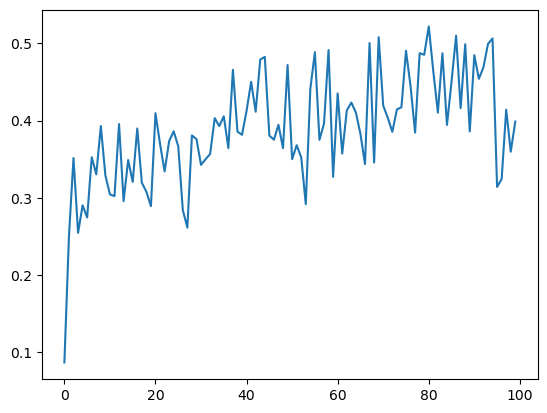

In [13]:
import matplotlib.pyplot as plt
plt.plot(acc3)

In [14]:
acc3 = np.array(acc3)

In [15]:
np.save("acc_fedavg_cifar10.npy",acc3)

In [16]:
global_model.save("feddrop_cifar10.h5")

C:\Users\Divyansh Gupta\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [22]:
tf.__version__

'2.13.0'